# Предотвращение оттока сотрудников

Некая компания предоставила данные с характеристиками своих сотрудников. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. Основной задачей проекта является разработка предложения, которое поможет компании избежать финансовых потерь и оттока сотрудников

---
**Цель исследования:** разработать две модели машинного обучения, прогнозирующие уровень удовлетворённости сотрудника и его увольнение

---

**План выполнения работы:**

`Задача 1. Предсказание уровня удовлетворённости сотрудника`
Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.
Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник

`Задача 2. Предсказание увольнения сотрудника из компании`
Построить модель, которая сможет на основе данных заказчика предсказать увольнение сотрудника

Для каждой из двух задач выполняются следующие шаги:
- загрузка и предварительное изучение данных
- предобработка данных
- исследовательский анализ данных
- корреляционный анализ данных
- подготовка данных к обучению
- обучение моделей
- тестирование модели
<br></br>

---

Для первой задачи итоговая метрика SMAPE получившейся модели должна быть меньше или равна 15, для второй задачи целевой метрикой является ROC-AUC

---

In [1]:
# установка широкоформатного jupyter

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
# импорт библиотек

import os
import re
import phik
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import display

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyRegressor
from sklearn.dummy import DummyClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler

from sklearn.metrics import roc_auc_score, f1_score, mean_squared_error
from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
# константы

RANDOM_STATE = 42

TARGET_1 = 'job_satisfaction_rate'
TARGET_2 = 'quit'

TRAIN_DATA = 'D:\\datasets\\job\\train_job_satisfaction_rate.csv'
TEST_FEATURES = 'D:\\datasets\\job\\test_features.csv'
TEST_TARGET = 'D:\\datasets\\job\\test_target_job_satisfaction_rate.csv'
TRAIN_QUIT = 'D:\\datasets\\job\\train_quit.csv'
TEST_TARGET_QUIT = 'D:\\datasets\\job\\test_target_quit.csv'

PATHS_1 = [TRAIN_DATA, TEST_FEATURES, TEST_TARGET]
PATHS_2 = [TRAIN_QUIT, TEST_TARGET_QUIT]
NAMES_1 = ['train_data', 'test_features', 'test_target']
NAMES_2 = ['train_quit', 'test_target_quit']

---

In [4]:
def load_datasets(PATHS):
    
    """
    Функция load_datasets загружает csv-файлы, пути к которым хранятся в переменной PATHS
    
    Аргументы:
    PATHS (list) : список путей к файлам
    
    Возвращает:
    datasets (list) : список, содержащий в себе все загруженные таблицы
    
    """
    
    datasets = []

    for path in PATHS:
        try:
            data = pd.read_csv(path, sep=',')
            filename = os.path.basename(path)
            print(f'Файл {filename} успешно загружен!')
            datasets.append(data)
        except Exception as error:
            print(f'Упс, что-то пошло не так при загрузке файла {os.path.basename(path)}! Текст ошибки: {repr(error)}')

    return datasets

In [5]:
def get_info(data):
    
    """
    Функция get_info выводит на экран пять случайных строк таблицы и общую информацию, полученную с помощью info()

    Аргументы:
    data (DataFrame): датафрейм

    """
    
    print('Пять случайных строк таблицы:')
    display(data.sample(5))
    print(' ')
    print('Общая информация о таблице:')
    print(' ')
    print(data.info())

In [6]:
def preprocess(data, data_name):
    
    """
    Функция preprocess выводит на экран количество дубликатов и пропусков в датафрейме

    Аргументы:
    data (DataFrame) : датафрейм
    data_name (str) : название датафрейма
    
    """
    
    for col in data:
        isna_count = data[col].isna().sum()
        if isna_count > 0:
            print(f'Пропусков найдено в столбце {col}: {isna_count}')
    isna_total = data.isna().sum().sum()
    if isna_total == 0:
        print(f'В таблице {data_name} не найдено ни одного пропуска!')
        
    duplicates_count = data.duplicated().sum()
    if duplicates_count > 0:
        print(f'Дубликатов найдено в таблице {data_name}: {duplicates_count}')
    else:
        print(f'В таблице {data_name} не найдено ни одного дубликата!')

In [7]:
def hidden_duplicates(data):
        
    """
    Функция hidden_duplicates сохраняет все столбцы типа object и/или category в переменную columns, 
    выводит на экран уникальные значения в каждом из этих столбцов 

    Аргументы:
    data (DataFrame): датафрейм
    
    """
    
    columns = data.select_dtypes(include=['object', 'category']).columns
    
    for column in columns:
        unique_values = data[column].unique()
        print(f'Уникальные значения в столбце {column}: {unique_values}')

In [8]:
def value_counts(data, col, data_name):
                
    """
    Функция value_counts выводит на экран числовое распределение данных в категориальном столбце

    Аргументы:
    data (DataFrame) : датафрейм
    col (str) : столбец датафрейма
    data_name (str) : название датафрейма
    
    """
    
    print(f'Распределение данных в столбце {col} таблицы {data_name}:')
    print(' ')
    print(data[col].value_counts())

In [9]:
def describe(data, col, data_name):
                    
    """
    Функция describe выводит на экран числовое описание данных в количественном столбце

    Аргументы:
    data (DataFrame) : датафрейм
    col (str) : столбец датафрейма
    data_name (str) : название датафрейма
    
    """
    
    print(f'Числовое описание столбца {col} таблицы {data_name}:')
    print(' ')
    print(data[col].describe())

In [10]:
def two_features_barplot(data, col_1, col_2, title, xlabel, ylabel, legend_title):
    
    """
    Функция two_features_barplot строит столбчатую диаграмму,
    отображающую зависимость 
    
    Аргументы:
    data (DataFrame) : датафрейм
    col_1 (str) : название первого признака
    col_2 (str) : название второго признака
    title (str) : заголовок графика
    xlabel (str) : подпись оси X (соотносится с col_1)
    ylabel (str) : подпись оси Y
    legend_title (str) : подпись легенды (соотносится с col_2)
    
    """
    
    cross_tab_normalized = pd.crosstab(data[col_1], data[col_2], normalize='index') * 100
    cross_tab_normalized = cross_tab_normalized.reset_index().melt(id_vars=col_1, var_name=col_2, value_name='percentage')
    
    plt.figure(figsize=(10, 4))
    barplot = sns.barplot(data=cross_tab_normalized, x=col_1, y='percentage', hue=col_2)
    
    for p in barplot.patches:
        height = p.get_height()
        barplot.annotate(f'{height:.0f}%',
                         (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='center',
                         xytext=(0, 5),
                         textcoords='offset points',
                         fontsize=11)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(title=legend_title, loc='upper left', bbox_to_anchor=(1.01, 1), ncol=1)
    plt.tight_layout()
    plt.show()

In [11]:
def compare_barplots(data1, col1, xlabel1, title1, data2, col2, xlabel2, title2):
    
    """
    Функция compare_barplots выводит на экран две столбчатые диаграммы

    Аргументы:
    data1 (DataFrame) : первый датафрейм
    col1 (str) : название столбца первого датафрейма
    xlabel1 (str) : подпись оси Х для первого графика
    title1 (str) : название первого графика
    data2 (DataFrame) : второй датафрейм
    col2 (str) : название столбца второго датафрейма
    xlabel2 (str) : подпись оси Х для второго графика
    title2 (str) : название второго графика
    
    """
    
    sns.set(style='darkgrid')
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))

    max_y = 0

    for ax, data, col, xlabel, title in zip(
        axes, 
        [data1, data2], 
        [col1, col2], 
        [xlabel1, xlabel2], 
        [title1, title2]
    ):
        count_data = data[col].value_counts()
        percent_data = data[col].value_counts(normalize=True)
        count_data_ = count_data.reset_index()
        count_data_.columns = [col, 'count']
        percent_data_ = percent_data.reset_index()
        percent_data_.columns = [col, 'percent']
        data_new_ = count_data_.merge(percent_data_, on=col)

        unique_values = len(data_new_)
        palette = sns.color_palette('Blues', unique_values)

        sns.barplot(x=col, y='count', data=data_new_, hue=col, dodge=False, palette=palette, ax=ax, legend=False)

        for i, p in enumerate(ax.patches):
            ax.text(p.get_x() + p.get_width() / 2., p.get_height(), f"{data_new_['percent'].iloc[i]:.0%}",
                    fontsize=8, ha='center', va='bottom')

        ax.set_title(title, fontsize=16)
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Количество сотрудников')

        max_y = max(max_y, count_data_['count'].max())

    for ax in axes:
        ax.set_ylim(0, max_y * 1.1)
        
    plt.tight_layout()
    plt.show()

In [12]:
def compare_violins(data1, col1, title1, xlabel1, data2, col2, title2, xlabel2):
    
    """
    Функция compare_violins выводит на экран две горизонтальные скрипичные диаграммы рядом друг с другом

    Аргументы:

    data1 (DataFrame) : первый датафрейм
    col1 (str) : название столбца первого датафрейма
    title1 (str) : название первого графика
    xlabel1 (str) : подпись оси X для первого графика

    data2 (DataFrame) : второй датафрейм
    col2 (str) : название столбца второго датафрейма
    title2 (str) : название второго графика
    xlabel2 (str) : подпись оси X для второго графика
    
    """
    
    sns.set(style='darkgrid')
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))

    for ax, data, cols, xlabel, title in zip(
        axes, 
        [data1, data2], 
        [col1, col2], 
        [xlabel1, xlabel2], 
        [title1, title2]
    ):
        if isinstance(cols, str):
            cols = [cols]
        
        if len(cols) == 1:
            values = data[cols[0]].values
        else:
            values = [data[col].values for col in cols]

        sns.violinplot(data=values, palette='Blues', ax=ax, orient='h', dodge=False)

        ax.set_title(title, fontsize=16)
        ax.set_ylabel('Значения')
        ax.set_xlabel(xlabel)

    plt.tight_layout() 
    plt.show()

In [13]:
def twin_hists_normalized(data_1, data_2, col, bins, xlabel, title, xticks, label1, label2):
    
    """
    Функция hist_violin выводит на экран две совмещённые гистограммы для одного признака

    Аргументы:
    data_1 (DataFrame) : первый датафрейм
    data_2 (DataFrame) : второй датафрейм
    col (str) : название столбца с признаком
    bins (int) : количество корзин для гистограммы
    xlabel (str) : подпись оси X
    title (str) : название графика
    xticks : числовой диапазон по оси X
    label1 (str) : название первого датафрейма
    label2 (str) : название второго датафрейма
    
    """
    
    sns.set(style='darkgrid', palette='pastel')
    plt.figure(figsize=(20, 5))
    
    sns.histplot(data=data_1, x=col, kde=True, bins=bins, label=label1, color='skyblue', stat='density', common_norm=False)
    sns.histplot(data=data_2, x=col, kde=True, bins=bins, label=label2, color='indianred', stat='density', common_norm=False)
    
    plt.title(title, fontsize=16)
    plt.ylabel('Количество сотрудников')
    plt.xlabel(xlabel)
    plt.legend()
    plt.grid(True)
    plt.xticks(xticks)
    
    plt.show()

---

<div style="border: 1px solid rgba(28, 28, 28, 0.2); border-radius: 2px; background-color: rgba(255, 255, 255, 0.8); padding: 10px; font-size: 25px; color: rgba(28, 28, 28, 0.9);">
Задача 1. Предсказание уровня удовлетворённости сотрудника
</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Загрузка и предварительное изучение данных
</div>

---

In [14]:
# применим функцию load_datasets()

datasets_1 = load_datasets(PATHS_1)

Файл train_job_satisfaction_rate.csv успешно загружен!
Файл test_features.csv успешно загружен!
Файл test_target_job_satisfaction_rate.csv успешно загружен!


In [15]:
# сохраним таблицы в переменные с соответствующими им именами

for name, dataset in zip(NAMES_1, datasets_1):
    globals()[name] = dataset

---

In [16]:
# изучим общую информацию о таблице train_data

get_info(train_data)

Пять случайных строк таблицы:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
2484,296197,technology,junior,high,2,no,no,3,46800,0.57
2652,127632,marketing,middle,high,5,yes,no,4,52800,0.78
391,989771,sales,junior,medium,4,no,no,4,21600,0.73
453,191900,technology,junior,medium,3,no,no,3,30000,0.33
2285,849565,technology,junior,high,2,no,no,4,46800,0.79


 
Общая информация о таблице:
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
None


- таблица содержит 4000 строк и 10 столбцов
- данные соответствуют описанию
- обнаружены пропуски в столбцах `dept` и `level`

In [17]:
# изучим общую информацию о таблице test_features

get_info(test_features)

Пять случайных строк таблицы:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1808,550765,sales,middle,medium,4,no,no,4,33600
261,916041,sales,middle,high,6,no,no,4,52800
1465,848609,sales,sinior,low,10,no,no,4,32400
469,336423,purchasing,junior,medium,3,no,no,4,26400
1754,222426,technology,junior,medium,1,no,no,3,33600


 
Общая информация о таблице:
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
None


- таблица содержит 2000 строк и 9 столбцов
- в таблице перечислены все входные признаки, но не целевой
- обнаружены пропуски в столбцах `dept` и `level`, как и в предыдущей таблице

In [18]:
# изучим общую информацию о таблице test_target

get_info(test_target)

Пять случайных строк таблицы:


,id,job_satisfaction_rate
1914,397917,0.57
312,698308,0.37
732,356822,0.51
1735,449661,0.56
736,815744,0.34


 
Общая информация о таблице:
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB
None


- таблица содержит 2000 строк и 2 cтолбца
- таблица состоит из одного целевого признака

<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">
Загруженные данные соответствуют описанию, типы данных во всех трёх таблицах определены верно. Названия столбцов не требуют переименования
</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Предобработка данных
</div>

---

### `train_data`

In [19]:
# применим функцию preprocess

preprocess(train_data, 'train_data')

Пропусков найдено в столбце dept: 6
Пропусков найдено в столбце level: 4
В таблице train_data не найдено ни одного дубликата!


In [20]:
# избаимся от найденных пропусков

train_data = train_data.dropna()

In [21]:
# выведем на экран уникальные значения каждого категориального столбца

hidden_duplicates(train_data)

Уникальные значения в столбце dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing']
Уникальные значения в столбце level: ['junior' 'middle' 'sinior']
Уникальные значения в столбце workload: ['medium' 'high' 'low']
Уникальные значения в столбце last_year_promo: ['no' 'yes']
Уникальные значения в столбце last_year_violations: ['no' 'yes']


In [22]:
# заменим ошибку в столбце level

train_data['level'].replace('sinior', 'senior', inplace=True)

C:\Users\User_\AppData\Local\Temp\ipykernel_7712\990962401.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['level'].replace('sinior', 'senior', inplace=True)


In [23]:
# проверим результат

print(f"Обновлённый список уникальных значений в столбце level: {train_data['level'].unique()}")

Обновлённый список уникальных значений в столбце level: ['junior' 'middle' 'senior']


In [24]:
# проверим размерность таблицы

print(f'Размерность таблицы train_data после предобработки данных: {train_data.shape}')

Размерность таблицы train_data после предобработки данных: (3990, 10)


### `test_features`

In [25]:
# применим функцию preprocess

preprocess(test_features, 'test_features')

Пропусков найдено в столбце dept: 2
Пропусков найдено в столбце level: 1
В таблице test_features не найдено ни одного дубликата!


In [26]:
# выведем на экран уникальные значения каждого категориального столбца

hidden_duplicates(test_features)

Уникальные значения в столбце dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Уникальные значения в столбце level: ['junior' 'middle' 'sinior' nan]
Уникальные значения в столбце workload: ['medium' 'low' 'high' ' ']
Уникальные значения в столбце last_year_promo: ['no' 'yes']
Уникальные значения в столбце last_year_violations: ['no' 'yes']


In [27]:
# заменим аналогичную ошибку в столбце level

test_features['level'].replace('sinior', 'senior', inplace=True)

In [28]:
# заменим пробелы в значениях на значения nan для последующей обработки

test_features['dept'].replace(' ', np.nan, inplace=True)
test_features['workload'].replace(' ', np.nan, inplace=True)

In [29]:
# проверим результат

print(f"Обновлённый список уникальных значений в столбце level: {test_features['level'].unique()}")
print(f"Обновлённый список уникальных значений в столбце dept: {test_features['dept'].unique()}")
print(f"Обновлённый список уникальных значений в столбце workload: {test_features['workload'].unique()}")

Обновлённый список уникальных значений в столбце level: ['junior' 'middle' 'senior' nan]
Обновлённый список уникальных значений в столбце dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
Обновлённый список уникальных значений в столбце workload: ['medium' 'low' 'high' nan]


In [30]:
# применим функцию preprocess

preprocess(test_features, 'test_features')

Пропусков найдено в столбце dept: 3
Пропусков найдено в столбце level: 1
Пропусков найдено в столбце workload: 1
В таблице test_features не найдено ни одного дубликата!


### `test_target`

In [31]:
# проверим таблицу на наличие дубликатов

print(f'Дубликатов найдено: {test_target.duplicated().sum()}')

Дубликатов найдено: 0


<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">
Предобработка данных завершена. Дубликатов в данных нет, ошибки в значениях столбцов устранены, пробелы заменены на NaN. Обработка пропусков будет произведена в пайплайне
</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Исследовательский анализ данных
</div>

---

### `dept`

In [32]:
# выведем на экран числовое распределение данных

value_counts(train_data, 'dept', 'train_data')
print(' ')
value_counts(test_features, 'dept', 'test_features')

Распределение данных в столбце dept таблицы train_data:
 
dept
sales         1508
technology     866
purchasing     610
marketing      550
hr             456
Name: count, dtype: int64
 
Распределение данных в столбце dept таблицы test_features:
 
dept
sales         763
technology    455
marketing     279
purchasing    273
hr            227
Name: count, dtype: int64


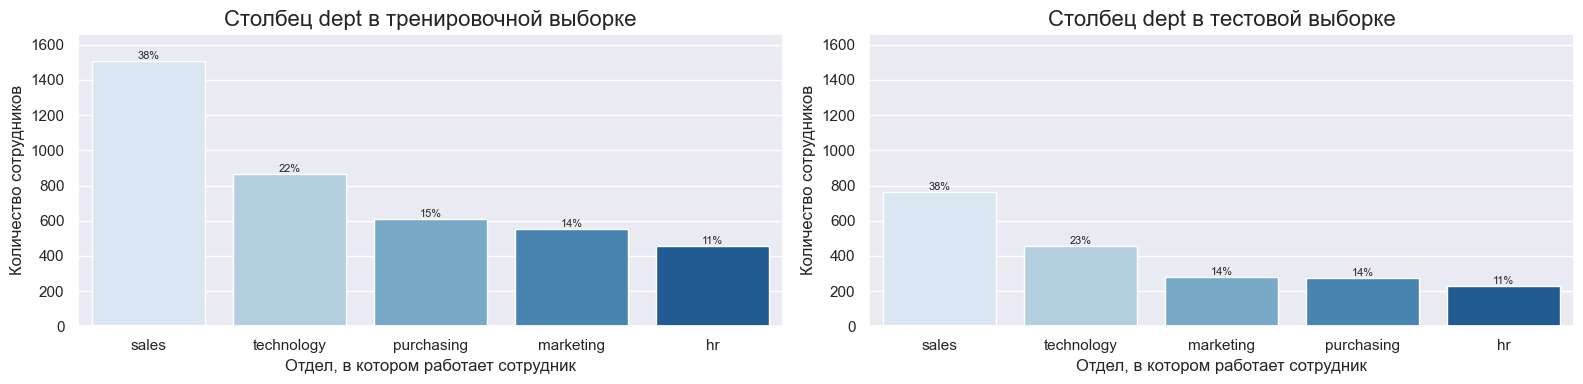

In [33]:
# построим пару столбчатых диаграмм для таблиц train_data и test_features

compare_barplots(
    train_data, 'dept', 'Отдел, в котором работает сотрудник', 'Столбец dept в тренировочной выборке',
    test_features, 'dept', 'Отдел, в котором работает сотрудник', 'Столбец dept в тестовой выборке'
)

Если в тренировочной выборке отдел `purchasing` находится на третьем месте по численности сотрудников, а `marketing` - на четвёртом, то в тестовой выборке они поменялись местами. В остальном распределение людей по отделам идентично. Так, больше всего сотрудников сосредоточены в отделе продаж, на втором месте — отдел технологий, на последнем — HR

### `level`

In [34]:
# выведем на экран числовое распределение данных

value_counts(train_data, 'level', 'train_data')
print(' ')
value_counts(test_features, 'level', 'test_features')

Распределение данных в столбце level таблицы train_data:
 
level
junior    1888
middle    1744
senior     358
Name: count, dtype: int64
 
Распределение данных в столбце level таблицы test_features:
 
level
junior    974
middle    854
senior    171
Name: count, dtype: int64


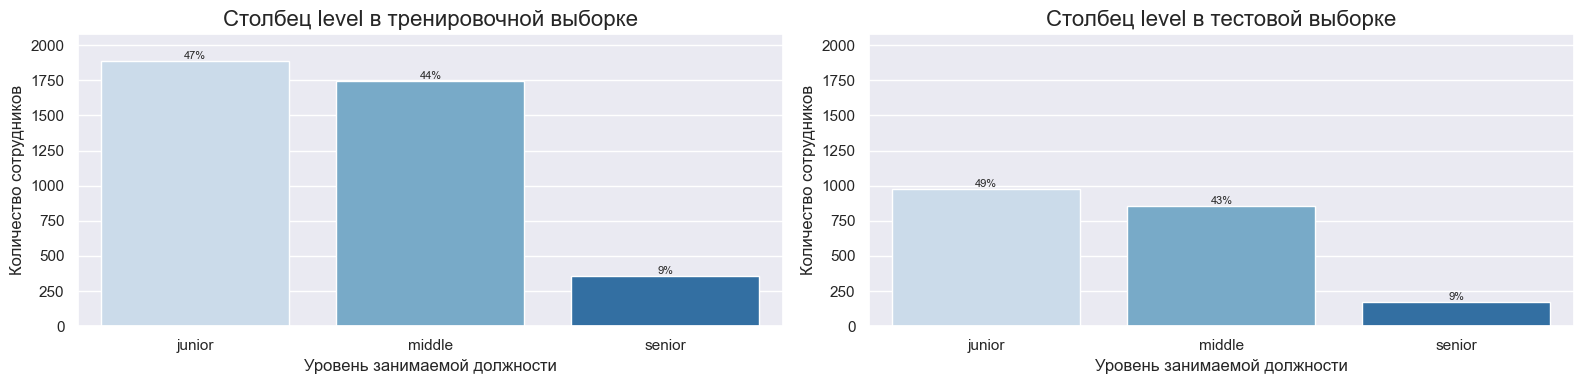

In [35]:
# построим пару столбчатых диаграмм для таблиц train_data и test_features

compare_barplots(
    train_data, 'level', 'Уровень занимаемой должности', 'Столбец level в тренировочной выборке',
    test_features, 'level', 'Уровень занимаемой должности', 'Столбец level в тестовой выборке'
)

Эти графики показывают распределение сотрудников по уровню занимаемой должности. Так, в обеих выборках большую часть сотрудников ожидаемо составляют джуниоры, на втором месте (с не очень большим отрывом) находятся миддлы, в третьей же группе — самые опытные сотрудники, и их число не превышает 8% для каждой из выборок

### `workload`

In [36]:
# выведем на экран числовое распределение данных

value_counts(train_data, 'workload', 'train_data')
print(' ')
value_counts(test_features, 'workload', 'test_features')

Распределение данных в столбце workload таблицы train_data:
 
workload
medium    2060
low       1197
high       733
Name: count, dtype: int64
 
Распределение данных в столбце workload таблицы test_features:
 
workload
medium    1043
low        593
high       363
Name: count, dtype: int64


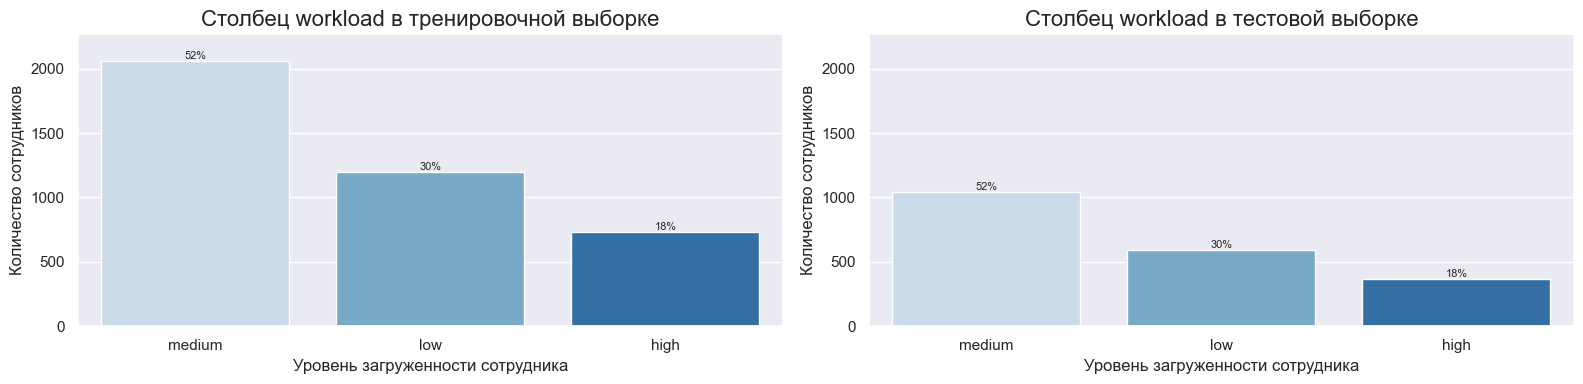

In [37]:
# построим пару столбчатых диаграмм для таблиц train_data и test_features

compare_barplots(
    train_data, 'workload', 'Уровень загруженности сотрудника', 'Столбец workload в тренировочной выборке',
    test_features, 'workload', 'Уровень загруженности сотрудника', 'Столбец workload в тестовой выборке'
)

Видим, что около 50% в каждой выборке составляют сотрудники со средним уровнем занятости. Чуть меньше — люди с низким уровнем загруженности. Высокий уровень загруженности имеет самая малочисленная группа сотрудников. Интересно было бы посмотреть, есть ли взаимосвязь между уровнем загруженности сотрудника и его опытностью

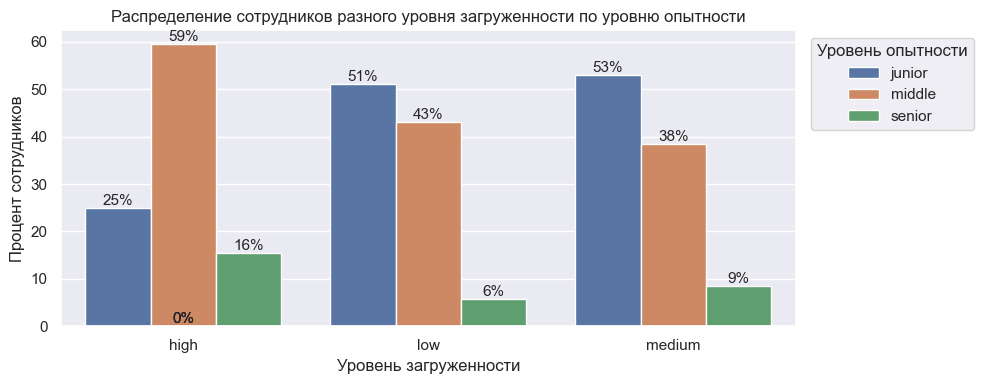

In [38]:
# посмотрим, как распределены сотрудники разной опытности по степени их загруженности

two_features_barplot(
    train_data, 'workload', 'level',
    'Распределение сотрудников разного уровня загруженности по уровню опытности',
    'Уровень загруженности', 'Процент сотрудников', 'Уровень опытности'
)

Среди сотрудников с самым высоким уровнем загруженности наиболее распространены миддлы, на втором месте — джуниоры, сеньоры — на последнем. Среди тех, чей уровень загруженности является низким, меньший процент составляют сеньоры, больший — джуниоры. То есть, больше половины сотрудников с низким уровнем загруженности составляют джуниоры

### `employment_years`

In [39]:
# выведем на экран числовое распределение данных

describe(train_data, 'employment_years', 'train_data')
print(' ')
describe(test_features, 'employment_years', 'test_features')

Числовое описание столбца employment_years таблицы train_data:
 
count    3990.000000
mean        3.722055
std         2.543715
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64
 
Числовое описание столбца employment_years таблицы test_features:
 
count    2000.000000
mean        3.666500
std         2.537222
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


В двух выборках немного различается граница первого квартиля, отделяющего 25% данных — в тренировочной выборке он равен 2, а в тестовой — 1. Из этого следует, что первая выборка содержит в себе больше сотрудников, проработавших в компании два и более года, нежели вторая выборка. В среднем же сотрудники компании трудоустроились чуть больше трёх лет назад

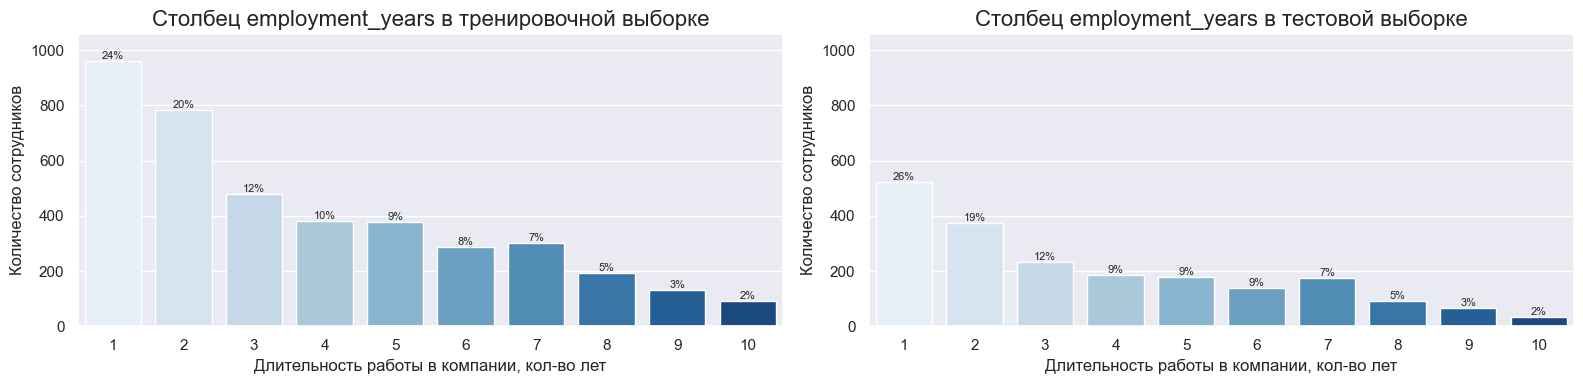

In [40]:
# построим пару столбчатых диаграмм для таблиц train_data и test_features

compare_barplots(
    train_data, 'employment_years', 'Длительность работы в компании, кол-во лет', 'Столбец employment_years в тренировочной выборке',
    test_features, 'employment_years', 'Длительность работы в компании, кол-во лет', 'Столбец employment_years в тестовой выборке'
)

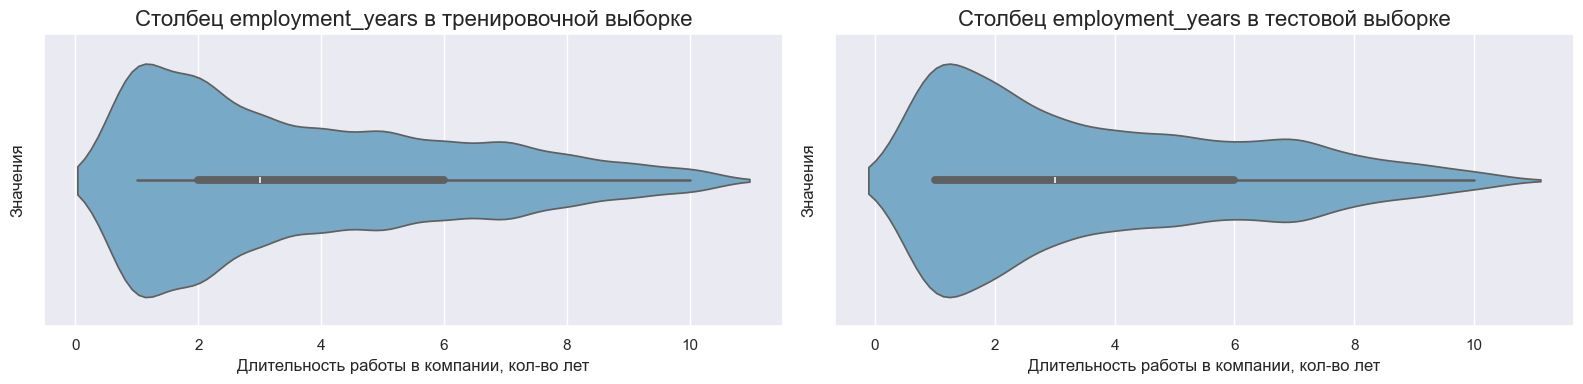

In [41]:
# построим пару скрипичных диаграмм для таблиц train_data и test_features

compare_violins(
    train_data, 'employment_years', 'Столбец employment_years в тренировочной выборке', 'Длительность работы в компании, кол-во лет',
    test_features, 'employment_years', 'Столбец employment_years в тестовой выборке', 'Длительность работы в компании, кол-во лет'   
)

Снова видим, что в тестовой выборке данные, находящиеся посередине шкалы, немного отличаются от тренировочных данных. Большую часть сотрудников составляют люди, проработавшие в компании от одного до трёх лет. Является ли такой показатель следствием масштабного набора сотрудников в последние три года или же высокой текучкой — неизвестно. Можно точно сказать, что сотрудники, проработавшие больше пяти лет, уже имеют определённый уровень лояльности к компании и, оптимистично предположим, высокий уровень удовлетворённости от работы

### `last_year_promo`

In [42]:
# выведем на экран числовое распределение данных

value_counts(train_data, 'last_year_promo', 'train_data')
print(' ')
value_counts(test_features, 'last_year_promo', 'test_features')

Распределение данных в столбце last_year_promo таблицы train_data:
 
last_year_promo
no     3870
yes     120
Name: count, dtype: int64
 
Распределение данных в столбце last_year_promo таблицы test_features:
 
last_year_promo
no     1937
yes      63
Name: count, dtype: int64


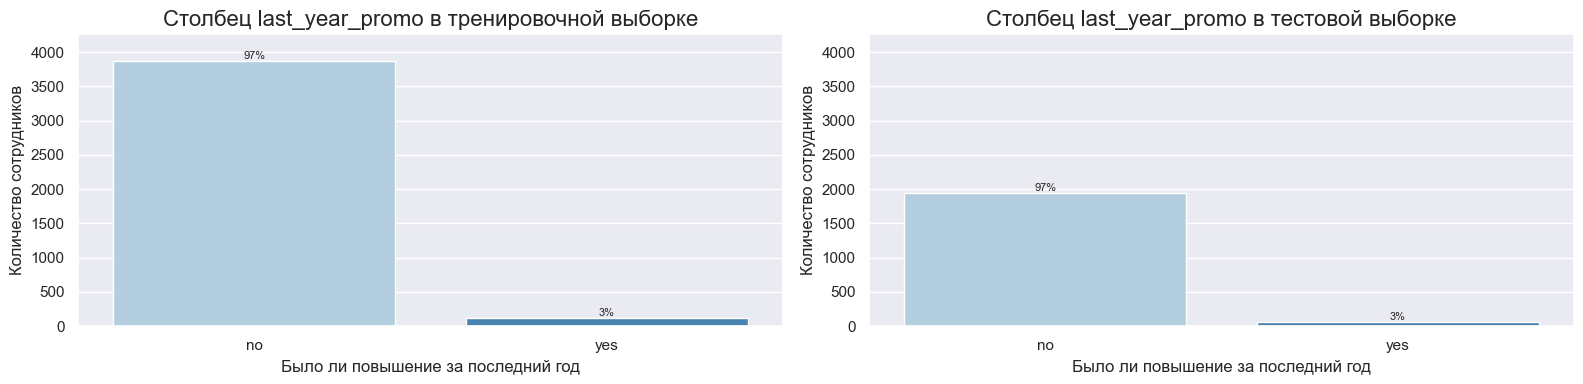

In [43]:
# построим пару столбчатых диаграмм для таблиц train_data и test_features

compare_barplots(
    train_data, 'last_year_promo', 'Было ли повышение за последний год', 'Столбец last_year_promo в тренировочной выборке',
    test_features, 'last_year_promo', 'Было ли повышение за последний год', 'Столбец last_year_promo в тестовой выборке'
)

В каждой из выборок процент сотрудников, получивших повышение, не превышает 3%

### `last_year_violations`

In [44]:
# выведем на экран числовое распределение данных

value_counts(train_data, 'last_year_violations', 'train_data')
print(' ')
value_counts(test_features, 'last_year_violations', 'test_features')

Распределение данных в столбце last_year_violations таблицы train_data:
 
last_year_violations
no     3432
yes     558
Name: count, dtype: int64
 
Распределение данных в столбце last_year_violations таблицы test_features:
 
last_year_violations
no     1738
yes     262
Name: count, dtype: int64


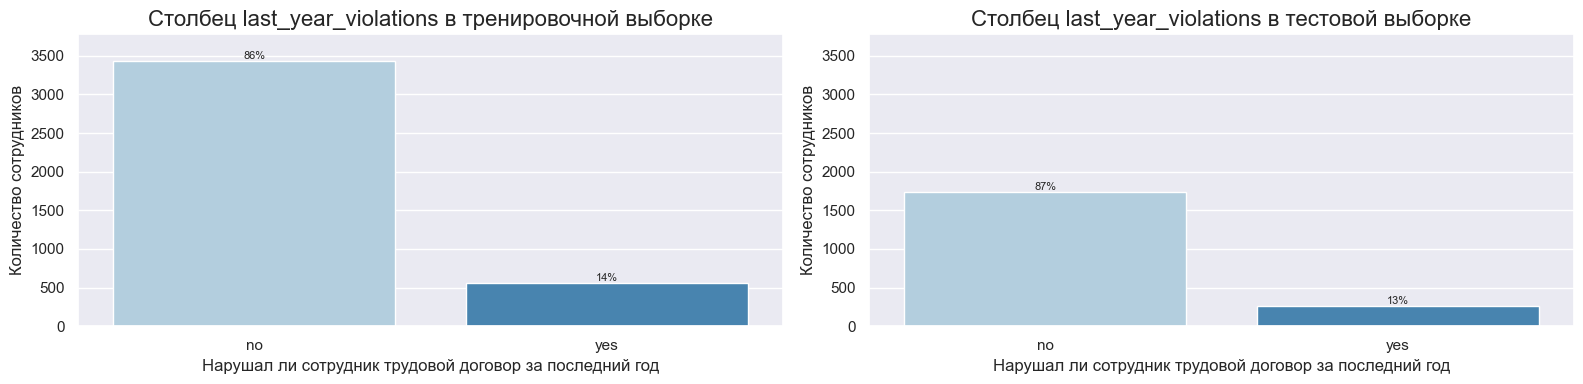

In [45]:
# построим пару столбчатых диаграмм для таблиц train_data и test_features

compare_barplots(
    train_data, 'last_year_violations', 'Нарушал ли сотрудник трудовой договор за последний год', 'Столбец last_year_violations в тренировочной выборке',
    test_features, 'last_year_violations', 'Нарушал ли сотрудник трудовой договор за последний год', 'Столбец last_year_violations в тестовой выборке'
)

13% сотрудников за последний год хотя бы раз нарушали трудовой договор. Интересно было бы взглянуть, коррелирует ли нарушение договора с низким уровнем удовлетворённости работой

### `supervisor_evaluation`

In [46]:
# выведем на экран числовое распределение данных

value_counts(train_data, 'supervisor_evaluation', 'train_data')
print(' ')
value_counts(test_features,  'supervisor_evaluation', 'test_features')

Распределение данных в столбце supervisor_evaluation таблицы train_data:
 
supervisor_evaluation
4    1597
3    1261
5     544
2     387
1     201
Name: count, dtype: int64
 
Распределение данных в столбце supervisor_evaluation таблицы test_features:
 
supervisor_evaluation
4    857
3    575
5    284
2    196
1     88
Name: count, dtype: int64


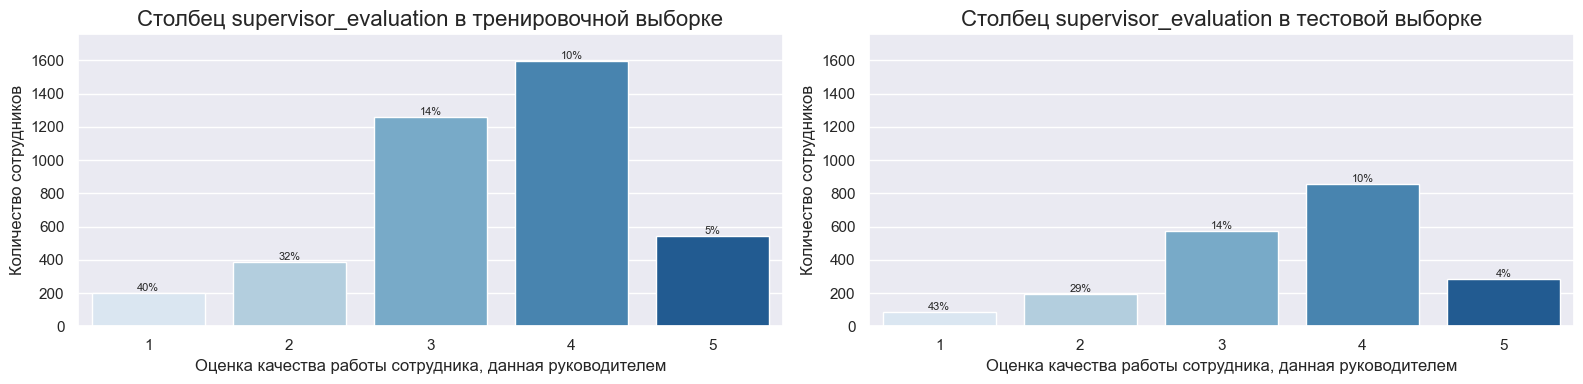

In [47]:
# построим пару столбчатых диаграмм для таблиц train_data и test_features

compare_barplots(
    train_data, 'supervisor_evaluation', 'Оценка качества работы сотрудника, данная руководителем', 'Столбец supervisor_evaluation в тренировочной выборке',
    test_features, 'supervisor_evaluation', 'Оценка качества работы сотрудника, данная руководителем', 'Столбец supervisor_evaluation в тестовой выборке'
)

Данные в обеих выборках распределены совершенно одинаково. Так, работу большинства сотрудников руководители оценивают на четвёрку и тройку, и лишь малый процент людей получает самую высокую или самые низкие оценки. Здесь также было бы интересно взглянуть, есть ли взаимосвязь между качеством работы сотрудника и его удовлетворённостью. Это показало бы и объективность оценок, данных руководителем

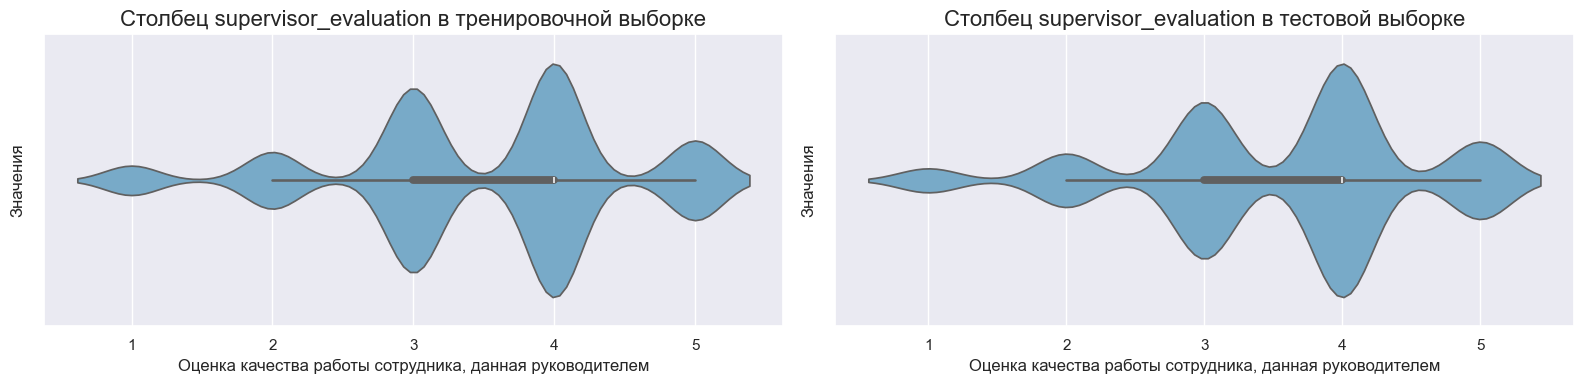

In [48]:
# построим пару скрипичных диаграмм для таблиц train_data и test_features

compare_violins(
    train_data, 'supervisor_evaluation', 'Столбец supervisor_evaluation в тренировочной выборке', 'Оценка качества работы сотрудника, данная руководителем',
    test_features, 'supervisor_evaluation', 'Столбец supervisor_evaluation в тестовой выборке', 'Оценка качества работы сотрудника, данная руководителем'   
)

Скрипичные диаграммы являются практически идентичными для обеих выборок. Заметные выпуклые части графика связаны с тем, что значения оценок являются не непрерывными, а дискретными

### `salary`

In [49]:
# выведем на экран числовое распределение данных

describe(train_data, 'salary', 'train_data')
print(' ')
describe(test_features, 'salary', 'test_features')

Числовое описание столбца salary таблицы train_data:
 
count     3990.000000
mean     33953.383459
std      14907.247698
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64
 
Числовое описание столбца salary таблицы test_features:
 
count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64


В среднем, люди в этой компании получают зарплату 33-34 тысячи рублей. Минимальной зарплатой в компании является 12 тысяч рублей, максимальной — 96 тысяч рублей. Можно посмотреть внимательнее, в каком отделе сотрудники получают более высокую зарплату, а также зависит ли от зарплаты удовлетворённость сотрудника — хотя и кажется, что эти факты однозначно коррелируют, вполне может оказаться так, что в компании есть проблема, которая влияет на целевой признак даже несмотря на высокую зарплату сотрудника

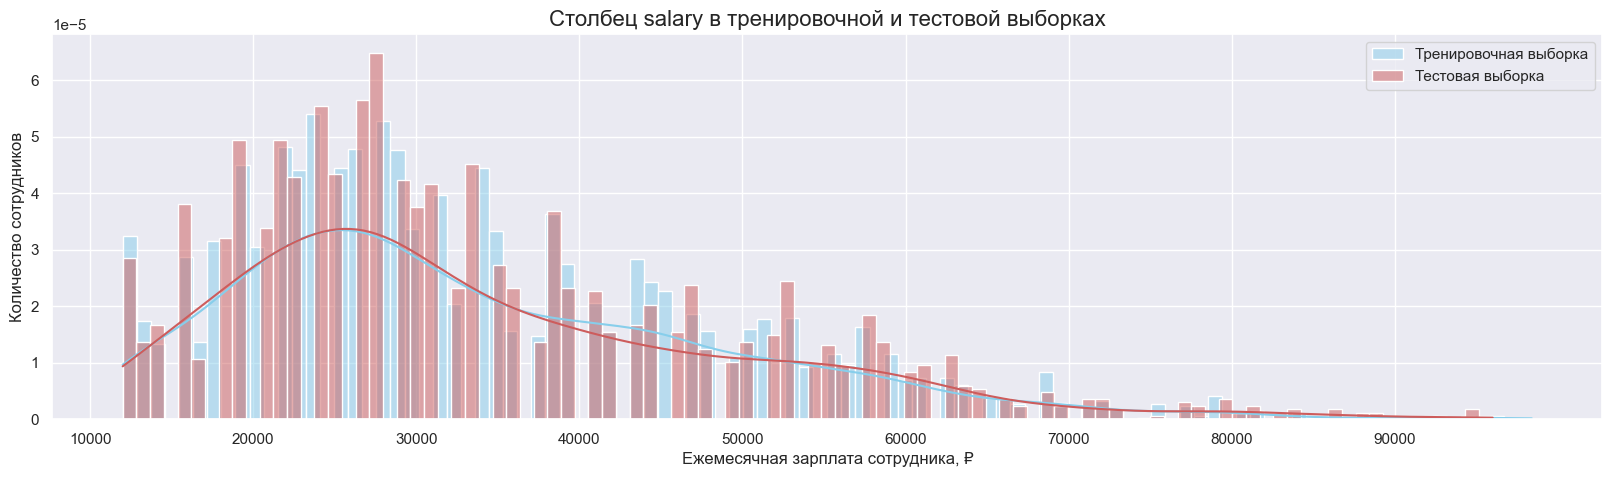

In [50]:
# построим пару гистограмм для таблиц train_data и test_features

twin_hists_normalized(
    train_data, test_features, 'salary', 100, 'Ежемесячная зарплата сотрудника, ₽', 
    'Столбец salary в тренировочной и тестовой выборках', range(10000, 100000, 10000),
    'Тренировочная выборка', 'Тестовая выборка'
)

Основная масса людей сосредоточена здесь в диапазоне от 12 тысяч рублей до примерно 40 тысяч рублей. Можно предположить, что высокую зарплату получают опытные сеньоры, сотрудники, работающие больше трёх-пяти лет или люди с высоким уровнем загруженности, а их количество относительно остальных сотрудников также является очень небольшим. Помним, что чуть больше половины от общего количества людей составляют джуниоры и сотрудники, проработавшие в компании менее трёх лет

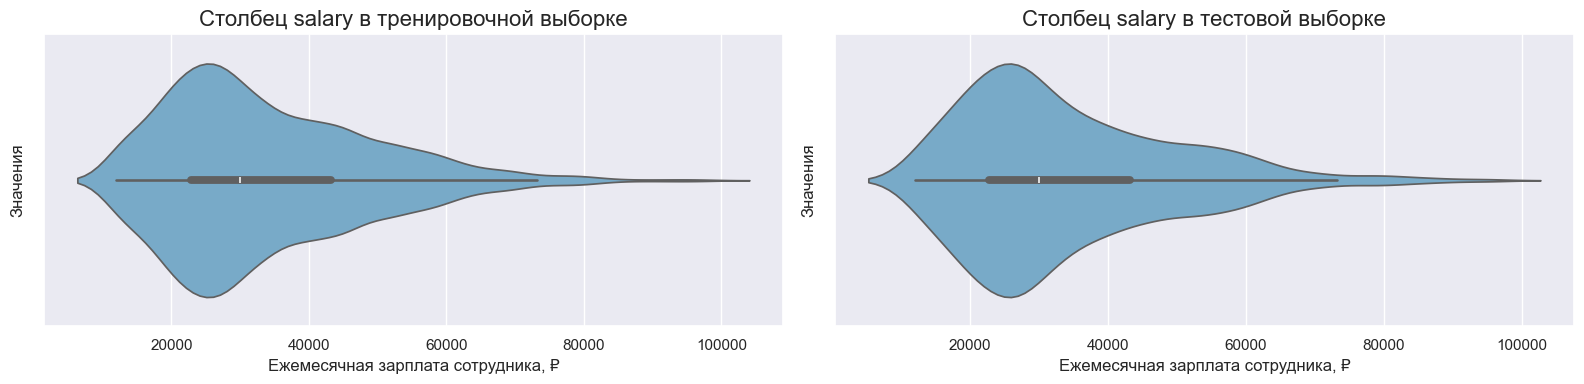

In [51]:
# построим пару скрипичных диаграмм для таблиц train_data и test_features

compare_violins(
    train_data, 'salary', 'Столбец salary в тренировочной выборке', 'Ежемесячная зарплата сотрудника, ₽',
    test_features, 'salary', 'Столбец salary в тестовой выборке', 'Ежемесячная зарплата сотрудника, ₽'   
)

Видим, что в тренировочной выборке данные распределяются более плавно. Скорее всего, это связано с бóльшим количеством наблюдений

### `job_satisfaction_rate`

In [52]:
# выведем на экран числовое описание целевого признака в тренировочной и тестовой выборках

describe(train_data, 'job_satisfaction_rate', 'train_data')
print(' ')
describe(test_target, 'job_satisfaction_rate', 'test_target')

Числовое описание столбца job_satisfaction_rate таблицы train_data:
 
count    3990.000000
mean        0.533772
std         0.225353
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64
 
Числовое описание столбца job_satisfaction_rate таблицы test_target:
 
count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64


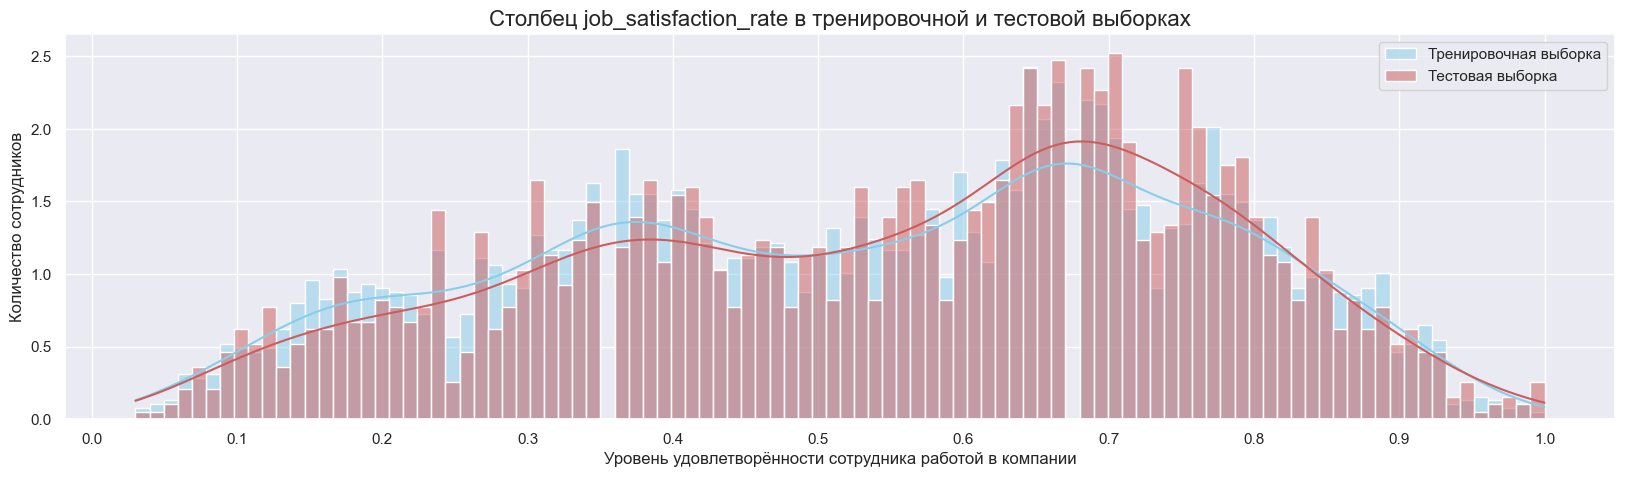

In [53]:
# построим гистограммы для целевого признака в тренировочной и тестовой выборках

xticks = np.arange(0, 1.1, 0.1)
twin_hists_normalized(
    train_data, test_target, 'job_satisfaction_rate', 100, 'Уровень удовлетворённости сотрудника работой в компании', 
    'Столбец job_satisfaction_rate в тренировочной и тестовой выборках', xticks,
    'Тренировочная выборка', 'Тестовая выборка'
)

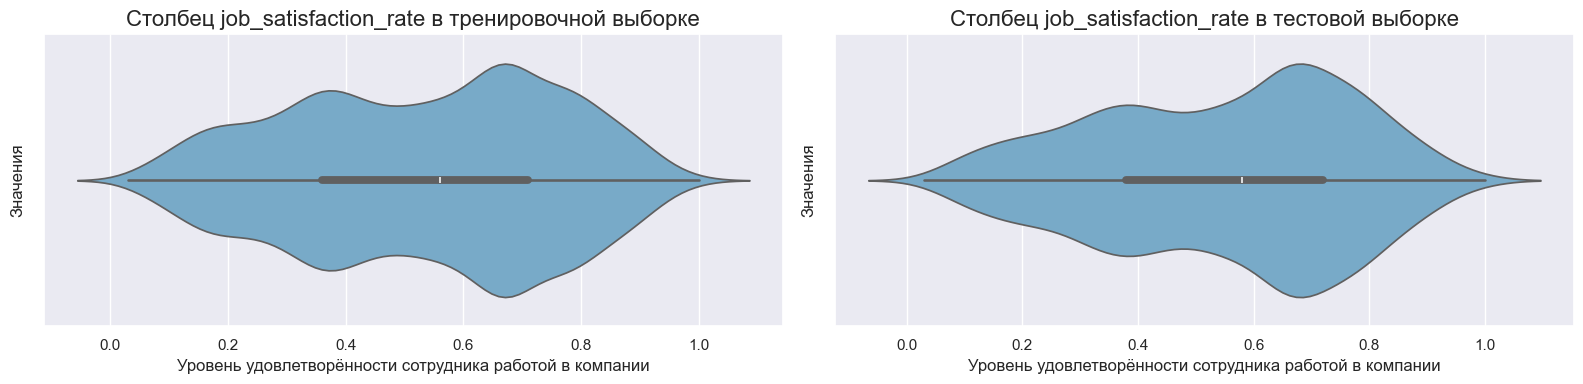

In [54]:
# построим скрипичные диаграммы для целевого признака в тренировочной и тестовой выборках

compare_violins(
    train_data, 'job_satisfaction_rate', 'Столбец job_satisfaction_rate в тренировочной выборке', 'Уровень удовлетворённости сотрудника работой в компании',
    test_target, 'job_satisfaction_rate', 'Столбец job_satisfaction_rate в тестовой выборке', 'Уровень удовлетворённости сотрудника работой в компании'   
)

Видим в данных целевого признака три *горба*: значения, сосредоточенные на отметках в 0.2, 0.4 и 0.7. Очень мало людей, имеющих уровень удовлетворённости выше 0.8, а распределение в столбце не отличаются у тестовой и тренировочной выборок

---

In [55]:
def barplot(data, col, xlabel, title):
            
    """
    Функция barplot выводит на экран готовую столбчатую диаграмму размером 8х4 дюйма, 
    содержащую значения относительно частоты встречаемых значений

    Аргументы:
    data (DataFrame) : датафрейм
    col (str) : столбец датафрейма
    xlabel (str) : подпись оси Х
    title (str) : название графика
    
    """
    
    sns.set(style='darkgrid')
    plt.figure(figsize=(10, 4))

    data_new = data[col].value_counts(normalize=True)
    data_new_ = data_new.reset_index()
    data_new_.columns = [col, 'count']
    
    unique_values = len(data_new_)
    palette = sns.color_palette('Blues', unique_values)
    
    ax = sns.barplot(x=col, y='count', data=data_new_, hue=col, dodge=False, palette=palette, legend=False)

    for p in ax.patches:
        ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '%d' % int(p.get_height() * 100) + '%',
                fontsize=8, ha='center', va='bottom')

    plt.title(title, fontsize=16)
    plt.xlabel(xlabel)
    plt.ylabel('Частота')

    plt.show()

---

Чтобы лучше понимать данные, необходимо взглянуть на них в разрезе целевого признака. Он является непрерывным, а потому необходимо разделить его на категории. Формировать категории с низким, средним и высоким уровнями удовлетворённости сотрудников мы не будем, так как данные о группе со средней удовлетворённостью не будут слишком информативны для нашего исследования. Гораздо лучше будет представить данные как два класса — сотрудник скорее удовлетворён и сотрудник скорее не удовлетворён, чтобы чётче увидеть разницу между этими классами, а также составить яркий портрет сотрудников обоих классов. Так, сотрудник, оценивший свою удовлетворённость в 0.6 или ниже — скорее НЕ удовлетворён работой, а сотрудник, поставивший оценку выше 0.6 — скорее удовлетворён, чем нет. Для этой части исследования будем использовать тренировочные данные

In [56]:
# сформируем срезы данных

low_rate = train_data.query('job_satisfaction_rate < 0.6')
high_rate = train_data.query('job_satisfaction_rate > 0.6')

---

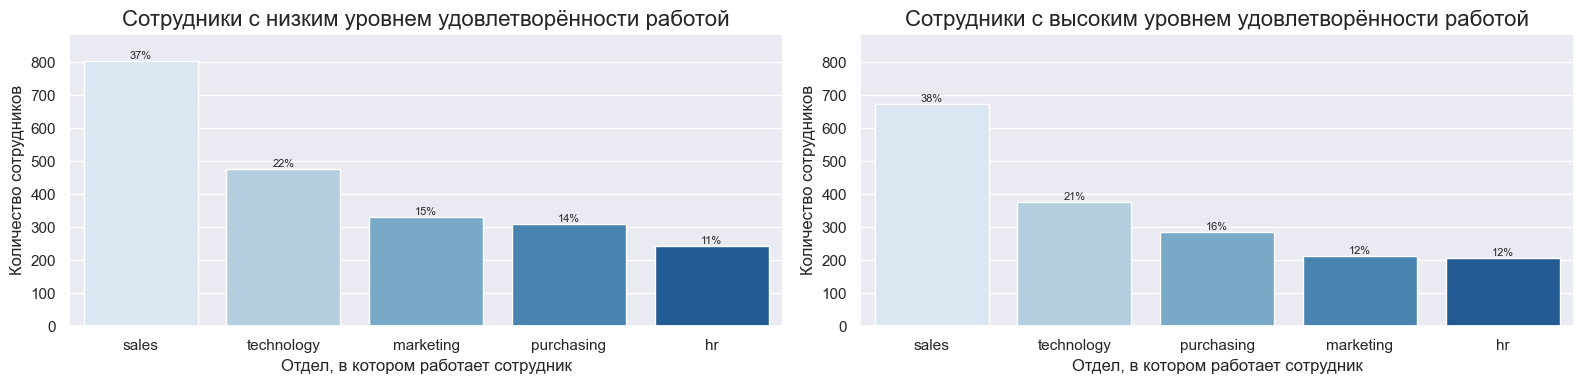

In [57]:
# построим пару столбчатых диаграмм

compare_barplots(
    low_rate, 'dept', 'Отдел, в котором работает сотрудник', 'Сотрудники с низким уровнем удовлетворённости работой',
    high_rate, 'dept', 'Отдел, в котором работает сотрудник', 'Сотрудники с высоким уровнем удовлетворённости работой'
)

Сотрудники первой группы на 3% чаще других работают в маркетинговом отделе, среди этой группы отдел занимает третье место, тогда как во второй он занимает предпоследнее место. Также люди первой группы на 1% чаще работают в отделе продаж и в отделе технологий

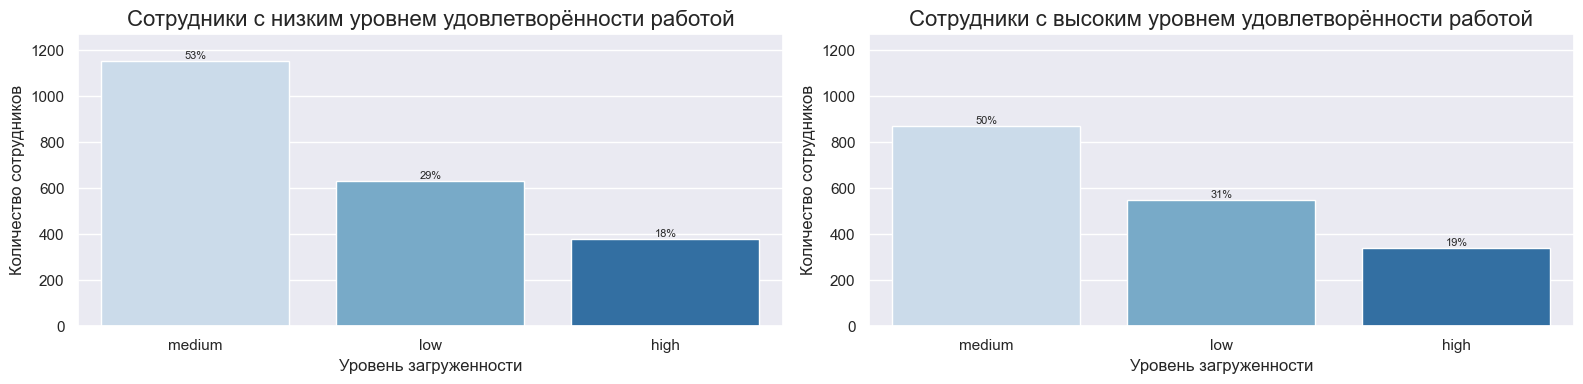

In [58]:
# построим пару столбчатых диаграмм

compare_barplots(
    low_rate, 'workload', 'Уровень загруженности', 'Сотрудники с низким уровнем удовлетворённости работой',
    high_rate, 'workload', 'Уровень загруженности', 'Сотрудники с высоким уровнем удовлетворённости работой'
)

Сотрудники с высоким уровнем удовлетворённости работой чаще имеют высокий и низкий уровни загруженности на 1% и 2% соответственно, нежели сотрудники с низким уровнем удовлетворённости. В первой группе на 3% больше людей имеют средний уровень рабочей нагрузки

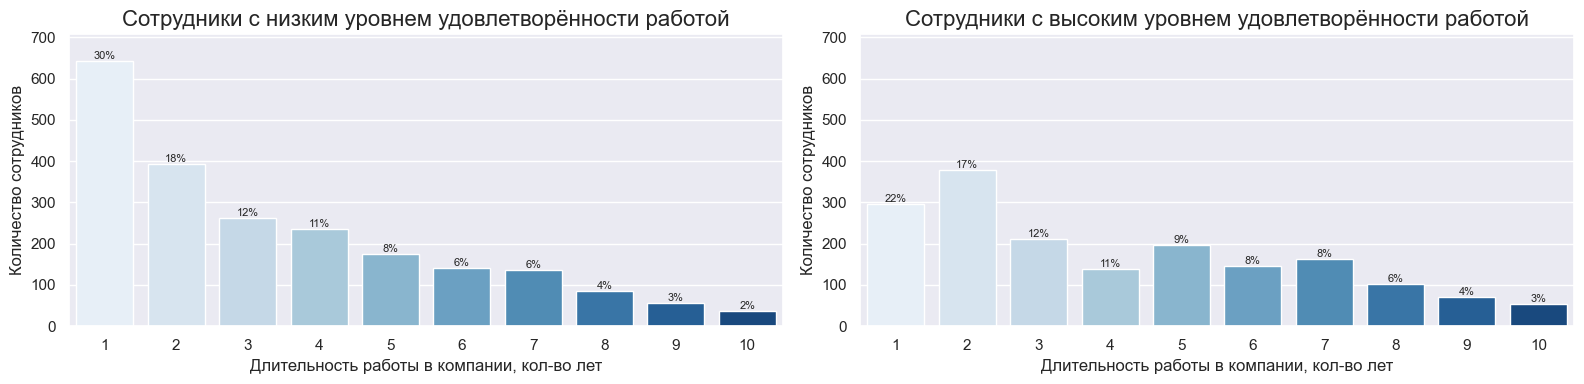

In [59]:
# построим пару столбчатых диаграмм

compare_barplots(
    low_rate, 'employment_years', 'Длительность работы в компании, кол-во лет', 'Сотрудники с низким уровнем удовлетворённости работой',
    high_rate, 'employment_years', 'Длительность работы в компании, кол-во лет', 'Сотрудники с высоким уровнем удовлетворённости работой'
)

В 60% случаев сотрудники, имеющие низкий уровень удовлетворённости, работали в компании до трёх лет. Во второй группе 62% составляют сотрудники, работавшие в компании до четырёх лет. При этом во второй группе работавших один год — на 8% меньше, чем в первой. Также вторая группа содержит больше сотрудников, количество лет в компании которых составляет больше четырёх лет

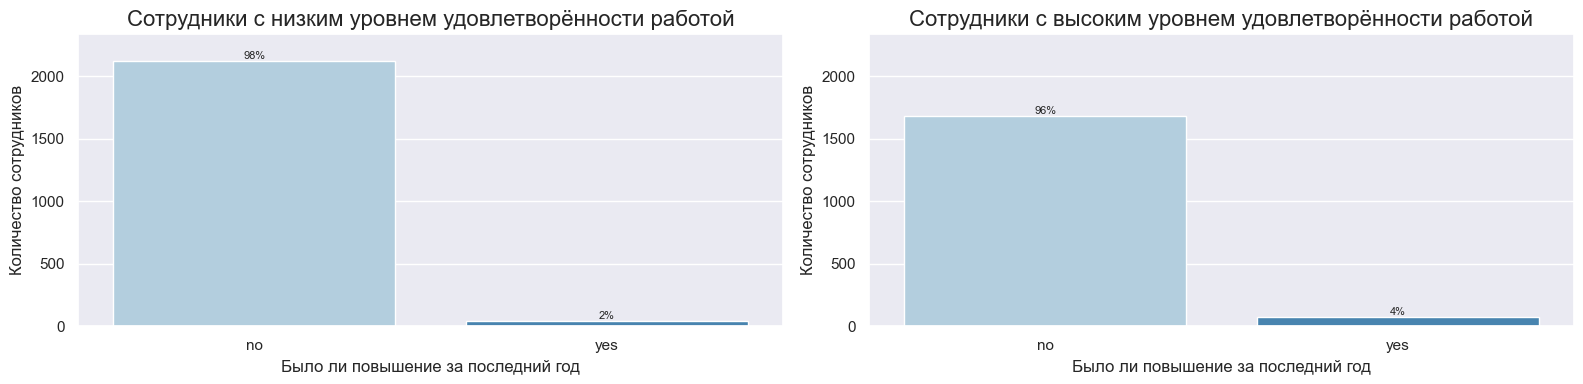

In [60]:
# построим пару столбчатых диаграмм

compare_barplots(
    low_rate, 'last_year_promo', 'Было ли повышение за последний год', 'Сотрудники с низким уровнем удовлетворённости работой',
    high_rate, 'last_year_promo', 'Было ли повышение за последний год', 'Сотрудники с высоким уровнем удовлетворённости работой'
)

Видим, что вторая группа получала повышение на 2% чаще. Нельзя доподлинно сказать, что именно повышение стимулировало удовлетворённость работой, так как уже было выяснено, что сотрудники с низким уровнем удовлетворённости преимущественно работали в компании не больше двух лет. За такой короткий срок тяжело говорить о продвижении по карьерной лестнице, тогда как у сотрудников, которые дольше работают в компании, шанс получить повышение намного выше

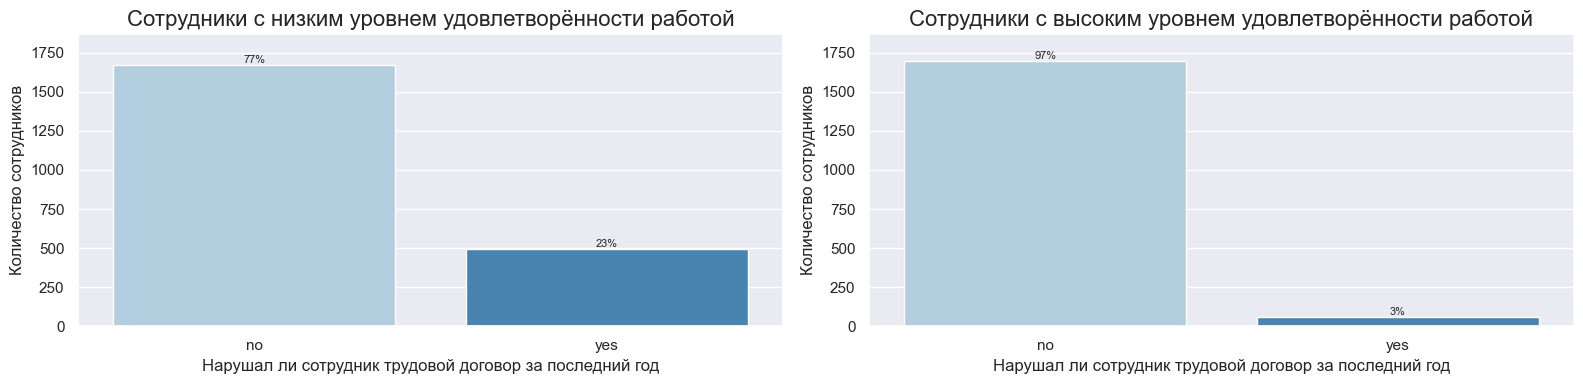

In [61]:
# построим пару столбчатых диаграмм

compare_barplots(
    low_rate, 'last_year_violations', 'Нарушал ли сотрудник трудовой договор за последний год', 'Сотрудники с низким уровнем удовлетворённости работой',
    high_rate, 'last_year_violations', 'Нарушал ли сотрудник трудовой договор за последний год', 'Сотрудники с высоким уровнем удовлетворённости работой'
)

Графики показывают, что неудовлетворённые работой сотрудники в 26% случаев нарушали трудовой договор, тогда как в другой группе процент нарушителей составляет всего 5%. Можно предположить, что нарушители не приходили на работу вовремя или пренебрегали выполнением некоторых обязанностей, что вполне соответствует портрету человека, недовольного местом своей работы

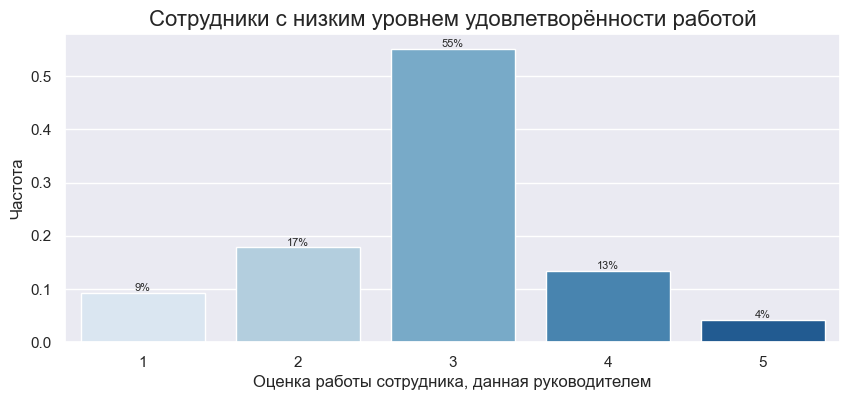

In [62]:
# выведем столбчатую диаграмму для столбца supervisor_evaluation в группе с низкой удовлетворённостью

barplot(low_rate, 'supervisor_evaluation', 'Оценка работы сотрудника, данная руководителем', 'Сотрудники с низким уровнем удовлетворённости работой')

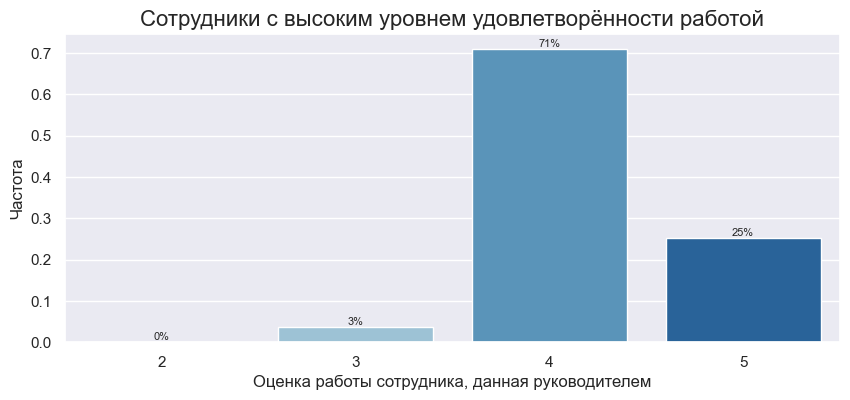

In [63]:
# выведем столбчатую диаграмму для столбца supervisor_evaluation в группе с высокой удовлетворённостью

barplot(high_rate, 'supervisor_evaluation', 'Оценка работы сотрудника, данная руководителем', 'Сотрудники с высоким уровнем удовлетворённости работой')

В 82% случаев сотрудники с низкой удовлетворённостью получали оценку не выше тройки, в то время как 96% сотрудников противоположной группы получали оценку выше четырёх 

In [64]:
# создадим копию тренировочных данных

train_data_copy = train_data.copy()

In [65]:
# сформируем новый столбец с категориями на основе целевого признака

def make_categories(rate):
    if rate < 0.6:
        return 'low'
    else:
        return 'high'

train_data_copy['rate_category'] = train_data['job_satisfaction_rate'].apply(make_categories)

In [66]:
# сформируем сводную таблицу со средней зарплатой в каждой исследуемой группе

pivot_table = train_data_copy.groupby('rate_category')['salary'].mean().reset_index()

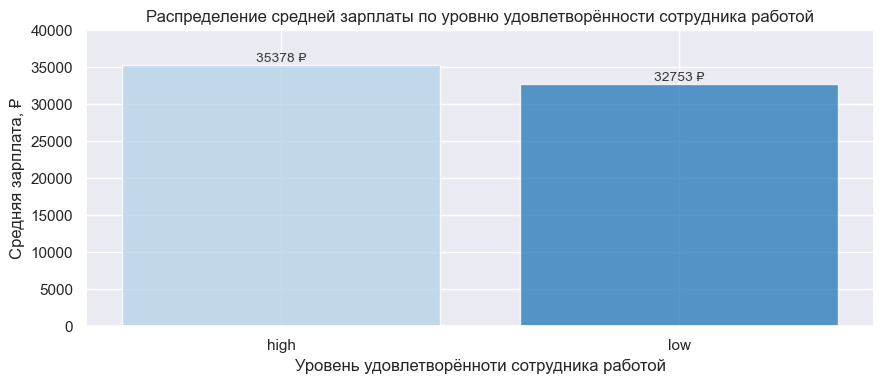

In [67]:
# построим для сводной таблицы столбчатую диаграмму

plt.figure(figsize=(9, 4))
colors = plt.cm.Blues(np.linspace(0.3, 0.7, len(pivot_table)))
bars = plt.bar(
    pivot_table['rate_category'], 
    pivot_table['salary'], 
    color=colors, 
    alpha=0.8
)
plt.xlabel('Уровень удовлетворённоти сотрудника работой')
plt.ylabel('Средняя зарплата, ₽')
plt.title('Распределение средней зарплаты по уровню удовлетворённости сотрудника работой')
plt.ylim(0, 40000)
plt.tight_layout()

for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        yval, 
        f'{yval:.0f} ₽', 
        ha='center', 
        va='bottom', 
        fontsize=10, 
        alpha=0.9
    )

plt.show()

Ожидаемо, самая высокий средний показатель заработной платы находится в группе сотрудников с высокой удовлетворённостью, и наоборот — сотрудники, недовольные работой, получают самую маленькую зарплату

In [68]:
# выведем на экран числовое описание признака salary в обеих группах

describe(low_rate, 'salary', 'low_rate')
print(' ')
describe(high_rate, 'salary', 'high_rate')

Числовое описание столбца salary таблицы low_rate:
 
count     2165.000000
mean     32752.517321
std      14595.830292
min      12000.000000
25%      21600.000000
50%      28800.000000
75%      42000.000000
max      92400.000000
Name: salary, dtype: float64
 
Числовое описание столбца salary таблицы high_rate:
 
count     1759.000000
mean     35379.874929
std      15129.455174
min      12000.000000
25%      24000.000000
50%      31200.000000
75%      44400.000000
max      98400.000000
Name: salary, dtype: float64


Медиана первой группы равна 28800, а у второй группы — 31200. Миниальная зарплата в обеих группах идентична, а вот максимальная отличается на 6000 в пользу второй группы

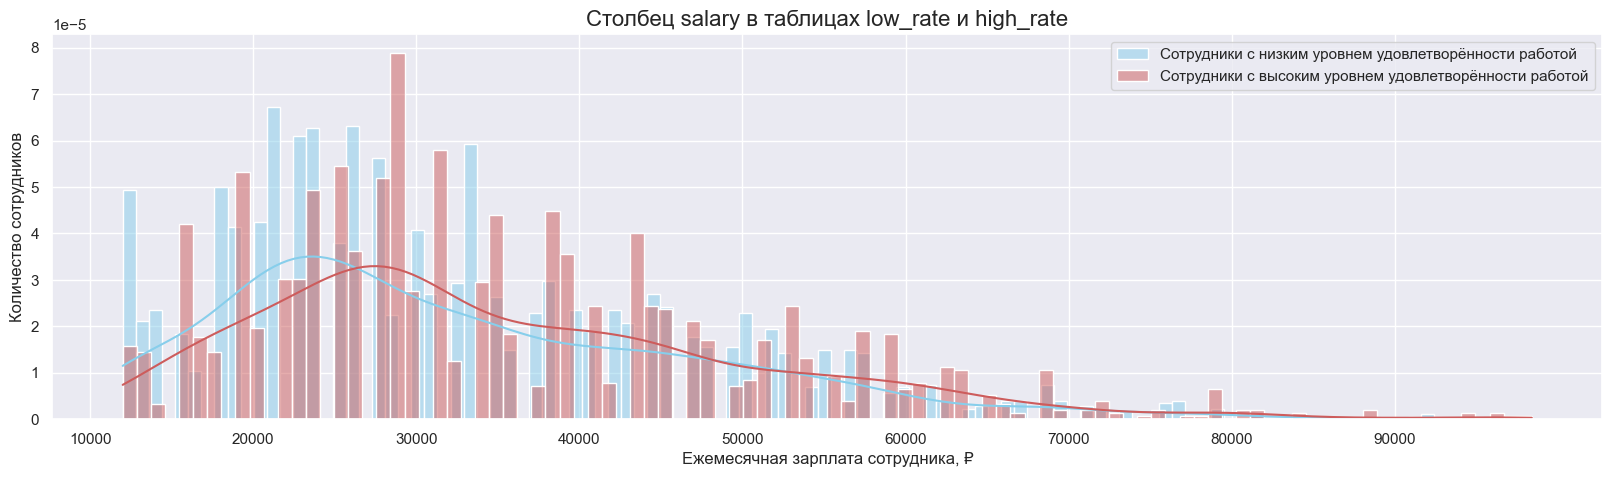

In [69]:
# построим пару гистограмм для таблиц low_rate и high_rate

twin_hists_normalized(
    low_rate, high_rate, 'salary', 100, 'Ежемесячная зарплата сотрудника, ₽', 
    'Столбец salary в таблицах low_rate и high_rate', range(10000, 100000, 10000),
    'Сотрудники с низким уровнем удовлетворённости работой',
    'Сотрудники с высоким уровнем удовлетворённости работой'
)

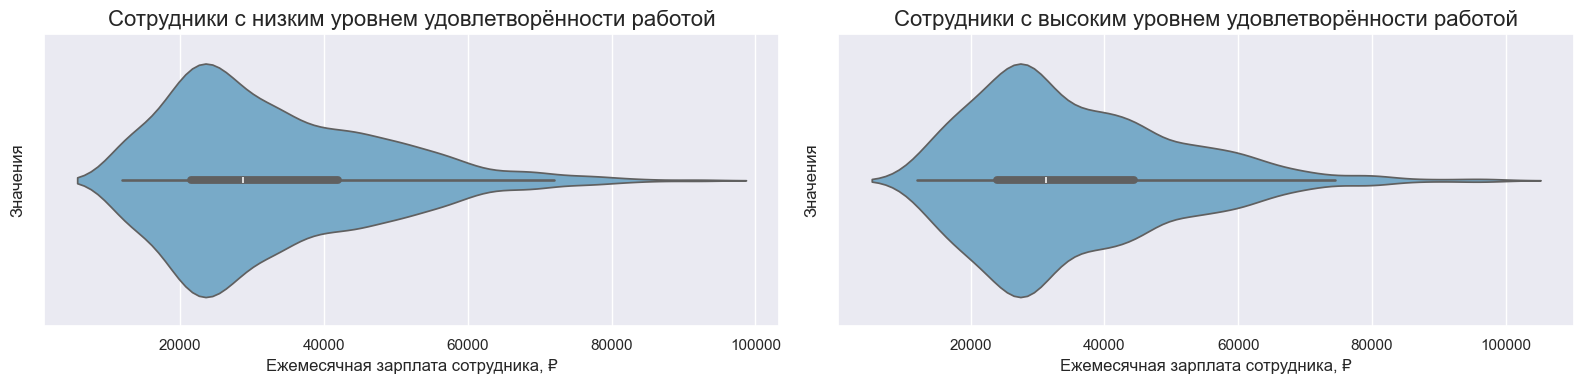

In [70]:
# построим пару скрипичных диаграмм для таблиц low_rate и high_rate

compare_violins(
    low_rate, 'salary', 'Сотрудники с низким уровнем удовлетворённости работой', 'Ежемесячная зарплата сотрудника, ₽',
    high_rate, 'salary', 'Сотрудники с высоким уровнем удовлетворённости работой', 'Ежемесячная зарплата сотрудника, ₽'   
)

И гистограмма, и скрипичная диаграмма показали, что пик значений у группы сотрудников с высоким уровнем удовлетворённости работой находится чуть правее, чем у первой группы. Это значит, что у второй группы больше значений сосредоточены вокруг более высокой суммы зарплаты, чем у первой группы. Неизвестно, как именно взаимосвязаны эти два признака и какой из них следует из другого — сотрудники могут быть недовольны работой из-за низкой зарплаты, а может, наоборот, их неудовлетворённость приводит к снижению продуктивности, что и приводит к меньшему заработку, например, в виде отсутствия премий или других поощрений

<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">
    
Каждый из имеющихся признаков исследован более подробно. В данных нет выбросов и аномалий, они выглядят адекватно и реалистично
    
</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Корреляционный анализ данных
</div>

---

In [71]:
def phik(data, interval_cols, title):
    
    """
    Функция single_phik выводит на экран матрицу корреляции phik

    Аргументы:
    data (DataFrame) : датафрейм
    interval_cols (list) : список названий столбцов, содержащих непрерывные количественные признаки
    title (str) : название графика
    
    """

    phik_matrix = data.phik_matrix(interval_cols=interval_cols)
    cmap = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)

    plt.figure(figsize=(17, 8))
    sns.heatmap(phik_matrix, annot=True, cmap=cmap, center=0, square=True, linewidths=.5)
    plt.title(title)
    plt.xticks(rotation=60)
    
    plt.show()

---

In [72]:
# избавимся от столбца id, сделав его индексом

train_data_corr = train_data.set_index('id')

In [73]:
# создадим список с наименованиями непрерывных признаков

interval_cols = ['salary', 'job_satisfaction_rate']

In [74]:
# объединим входные и целевой признаки для тестовых данных

test_data_corr = test_features.merge(test_target, on='id')
test_data_corr = test_data_corr.sort_values(by='id', ascending=True).set_index('id')

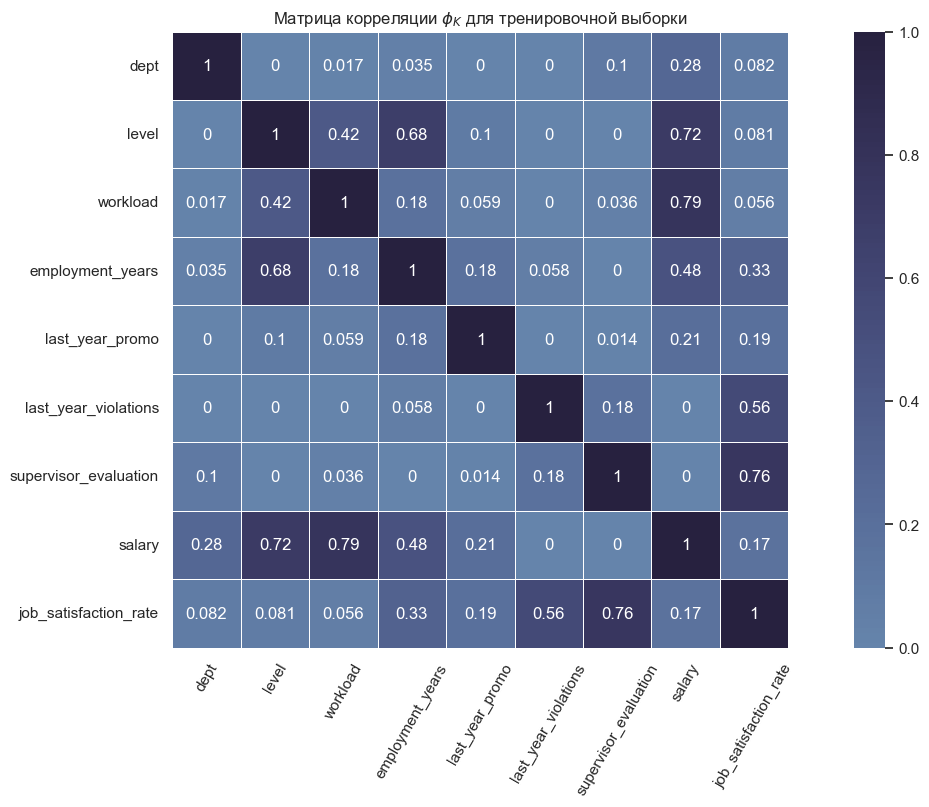

In [75]:
# выведем на экран матрицу корреляции для тренировочной выборки

phik(train_data_corr, interval_cols, 'Матрица корреляции $\phi_K$ для тренировочной выборки')

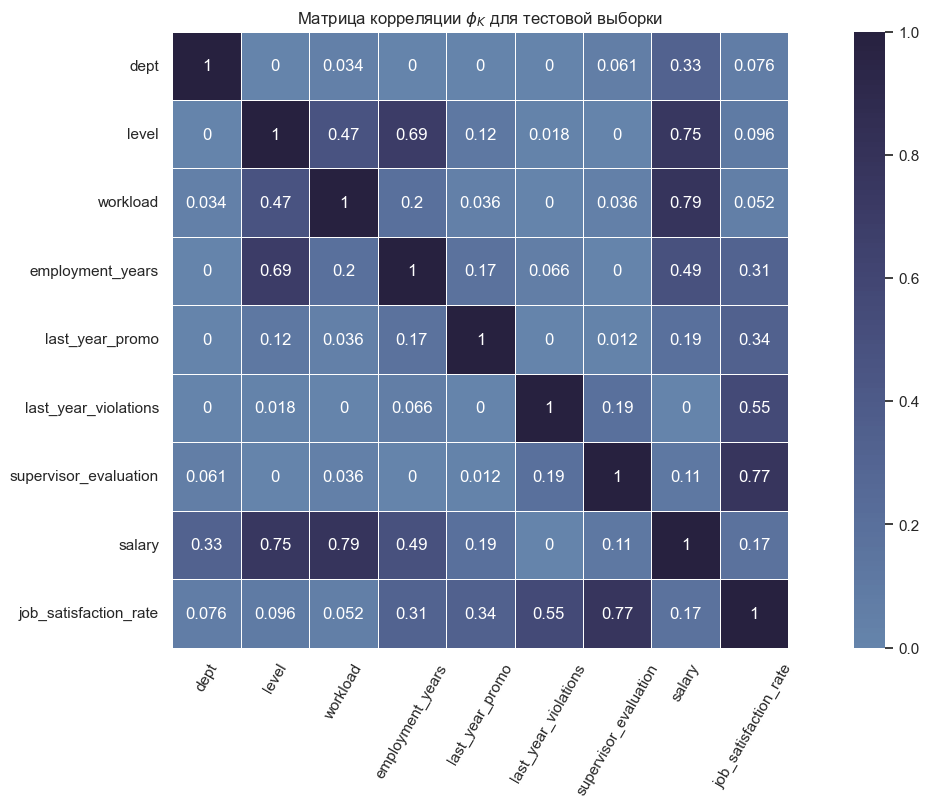

In [76]:
# выведем на экран матрицу корреляции для тестовой выборки

phik(test_data_corr, interval_cols, 'Матрица корреляции $\phi_K$ для тестовой выборки')

<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">
Взаимосвязь между уровнем загруженности сотрудника и его опытностью действительно есть и составляет от 0.42 до 0.47 в зависимости от выборки. Взаимосвязь положительная — это значит, что чем сотрудник опытнее, тем больше у него обязанностей в этой компании. Также уровень опыта сотрудника взаимосвязан с количеством лет его трудоустройства в компании, что абсолютно ожидаемо и логично.
    <br></br>
Больше всего целевой признак положительно коррелирует с количеством лет трудоустройства (как было предположено на этапе исследовательского анализа данных), имеющимся повышением, имеющимися нарушениями трудового договора (это неожиданно, ведь предполагалось обратное) и, сильнее всего, с оценкой качества работы, данной руководителем (признаки перечислены по мере возрастания корреляции). Ощутимая положительная корреляция последнего признака с целевым всё же не говорит об однозначной объективности оценки работы сотрудника. Непонятно, повышается ли уровень удовлетворённости от этой оценки, или наоборот — чем выше изначальный уровень удовлетворённости, тем лучше работает сотрудник и, следовательно, его хорошо оценивают.

Уровень зарплаты также ожидаемо высоко коррелирует с опытностью сотрудника, количеством лет, которые он проработал в компании, размером его загруженности и — несильно — с отделом, в котором он работает. Никаких других интересных взаимосвязей с зарплатой не найдено. Можно было бы предположить, что чем выше зарплата, тем выше и целевой признак, но это не так — корреляция в 0.14 - 0.15 говорит о том, что связь очень незначительная.

Признак `dept` не влияет абсолютно ни на один другой признак, кроме зарплаты.

Ни один коэффициент корреляции не является настолько высоким, чтобы говорить о мультиколлинеарности (как правило, о ней говорят при значении коэффициента корреляции от 0.9 до 0.95 по модулю). Можно переходить к следующему шагу
</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Подготовка данных к обучению
</div>

---

In [77]:
def size(data, data_name):
    
    """
    Функция size выводит на экран размерность датафрейма
    
    Аргументы:
    data (DataFrame) : датафрейм
    data_name (str) : название датафрейма
    
    """
    
    print(f'Размерность таблицы {data_name}: {data.shape}')

---

In [78]:
# тренировочные данные со столбцом id

train_target = train_data['job_satisfaction_rate']
train_features = train_data.drop('job_satisfaction_rate', axis=1)

In [79]:
# тренировочные данные без столбца id

train_data_no_id = train_data.set_index('id')
train_target_no_id = train_data_no_id['job_satisfaction_rate']
train_features_no_id = train_data_no_id.drop('job_satisfaction_rate', axis=1)

In [80]:
# проверим размерность таблиц

size(train_target, 'train_target')
size(train_features, 'train_features')
print(' ')
size(train_data_no_id, 'train_data_no_id')
size(train_target_no_id, 'train_target_no_id')
size(train_features_no_id, 'train_features_no_id')

Размерность таблицы train_target: (3990,)
Размерность таблицы train_features: (3990, 9)
 
Размерность таблицы train_data_no_id: (3990, 9)
Размерность таблицы train_target_no_id: (3990,)
Размерность таблицы train_features_no_id: (3990, 8)


In [81]:
# проверим таблицы на наличие дубликатов

print(f'Дубликатов найдено в таблице train_data_no_id: {train_data_no_id.duplicated().sum()}')
print(f'Дубликатов найдено в таблице train_target_no_id: {train_target_no_id.duplicated().sum()}')
print(f'Дубликатов найдено в таблице train_features_no_id: {train_features_no_id.duplicated().sum()}')

Дубликатов найдено в таблице train_data_no_id: 245
Дубликатов найдено в таблице train_target_no_id: 3892
Дубликатов найдено в таблице train_features_no_id: 1492


In [82]:
# удалим обнаруженные дубликаты

train_data_no_id = train_data_no_id.drop_duplicates()
train_target_no_id = train_target_no_id.drop_duplicates()
train_features_no_id = train_features_no_id.drop_duplicates()

---

In [83]:
# тестовые данные со столбцом id

test_data = test_features.merge(test_target, on='id')

In [84]:
# тестовые данные без столбца id

test_data_no_id = test_data.set_index('id')
test_target_no_id = test_data_no_id['job_satisfaction_rate']
test_features_no_id = test_data_no_id.drop('job_satisfaction_rate', axis=1)

In [85]:
# проверим размерность таблиц

size(test_data, 'test_data')
print(' ')
size(test_data_no_id, 'test_data_no_id')
size(test_target_no_id, 'test_target_no_id')
size(test_features_no_id, 'test_features_no_id')

Размерность таблицы test_data: (2000, 10)
 
Размерность таблицы test_data_no_id: (2000, 9)
Размерность таблицы test_target_no_id: (2000,)
Размерность таблицы test_features_no_id: (2000, 8)


---

In [86]:
# запишем признаки в переменные в соответствии с выбранным для них методом кодирования

ord_cols = ['level', 'workload']
ohe_cols = ['dept', 'last_year_promo', 'last_year_violations']
num_cols = ['employment_years', 'supervisor_evaluation']

In [87]:
# OneHotEncoder

ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe',
            SimpleImputer(strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
        )
    ]
)

In [88]:
# OrdinalEncoder

ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord',
             SimpleImputer(strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high'],
                ],
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord',
            SimpleImputer(strategy='most_frequent')
        )
    ]
)

In [89]:
# ColumnTransformer

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_cols),
        ('ord', ord_pipe, ord_cols),
        ('num', StandardScaler(), num_cols),
    ],
    remainder='passthrough'
)

In [90]:
# объединение шагов в итоговом пайплайне

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">
Тренировочные и тестовые данные были подготовлены к обучению. Создан пайплайн, который закодирует категориальные данные с помощью OneHotEncoder и OrdinalEncoder; если в данных во время или вследствие кодирования возникнут пропуски, они заполнятся самым часто встречающимся значением (модой) с помощью SimpleImputer. Третья труба data_preprocessor` применит OneHotEncoder и OrdinalEncoder к данным, которые требуют кодирования, а также масштабирует количественные данные с помощью StandardScaler. Итоговый пайплайн для подготовки данных будет назван pipe_final и объединит подготовку данных и инициализацию базовой модели — DecisionTreeRegressor
</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Обучение моделей
</div>

---

In [91]:
def smape(y_test, pred):
    
    """
    Функция smape вычисляет метрику SMAPE
    
    """
    
    error = abs(y_test - pred)
    scale = (abs(y_test) + abs(pred)) / 2 + 0.000000001
    result = 100 * (error / scale).mean()
    return result

---

In [92]:
# зададим параметры, которые будут перебираться для поиска лучших значений

param_grid_1 = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 20),
        'models__max_features': range(2,50),
        'models__min_samples_leaf': range(1,5),
        'models__min_samples_split': range(3, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
]

Для обучения и предсказания целевого признака, являющегося непрерывным значением, были выбраны такие модели, как `DecisionTreeRegressor` и `LinearRegression`. Линейная регрессия предполагает линейную зависимость между признаками и целевой переменной, а регрессия на основе деревьев использует комбинацию деревьев решений для предсказания целевой переменной

In [93]:
# инициализируем модель подбора гиперпараметров

rs_1 = RandomizedSearchCV(
    pipe_final,
    param_grid_1,
    cv=5,
    scoring=make_scorer(smape, greater_is_better=False),
    n_jobs=-1,
    random_state=RANDOM_STATE
    )

В качестве метрики выбрана SMAPE (Symmetric Mean Absolute Percentage Error). Это метрика, которая измеряет процентную ошибку прогноза и учитывает как его недооценку, так и переоценку. Чем ближе значение SMAPE к нулю, тем лучше

In [94]:
# запустим подбор гиперпараметров

rs_1.fit(train_features, train_target)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(s...
                                         'models__max_features': range(2, 50),
                                         'models__min_samples_leaf': range(1, 5),
                                         'models__min_samples_split': range(3, 20),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LinearRegression()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(smape, greater_is_better=False))

In [95]:
# выведем на экран лучшую модель и её параметры

print('Лучшая модель и её параметры:')
print(' ')
print(rs_1.best_estimator_)

Лучшая модель и её параметры:
 
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                   

In [96]:
# выведем на экран метрику SMAPE получившейся модели

print('Метрика SMAPE при кросс-валидации:', -rs_1.best_score_)

Метрика SMAPE при кросс-валидации: 15.312297159090667


In [97]:
# выполним предсказание на тестовой выборке

pred_1 = rs_1.predict(test_features)

In [98]:
# посчитаем метрику SMAPE на тестовой выборке

decision_tree_smape = smape(test_target_no_id, pred_1)
print(f'Метрика SMAPE на тестовой выборке: {decision_tree_smape}')

Метрика SMAPE на тестовой выборке: 14.361644877658836


<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

Получившаяся модель соответствуют критерию о целевой метрике. Можно приступить к тестированию модели 
    
</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Тестирование модели
</div>

---

In [99]:
def dummy_regressor_test(best_model_name):
    
    """
    Функция dummy_regressor_test инициализирует модель Dummy Regressor,
    обучает её на тренировочной выборке, выполняет предсказания на тестовой выборке,
    вычисляет метрику SMAPE, а затем строит сравнительную таблицу для тестовых значений
    лучшей модели и модели Dummy Regressor 
    
    Аргументы:
    model_name (str) : название модели
    
    Возвращает:
    dummy_result (DataFrame) : таблица со сравнительным результатом
    
    """
    
    dummy = DummyRegressor(strategy='mean')
    dummy.fit(train_features, train_target)
    dummy_pred = dummy.predict(test_features)
    dummy_smape = smape(test_target_no_id, dummy_pred)
    
    dummy_result = {
        'model': [best_model_name, 'dummy_regressor'],
        'SMAPE': [decision_tree_smape, dummy_smape]
    }
    
    dummy_result = pd.DataFrame(dummy_result)
    
    return dummy_result

In [100]:
# применим функцию dummy_regressor_test

dummy_result_1 = dummy_regressor_test('decision_tree_regressor')

# оценим результат

dummy_result_1

,model,SMAPE
0,decision_tree_regressor,14.361645
1,dummy_regressor,38.226050


<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

Проверка прошла успешно: очевидно, получившаяся модель не является бесполезной. Чем метрика SMAPE ниже, тем лучше — а у `DummyRegressor` она гораздо выше
    
</div>

In [101]:
# получим из пайплайна список названий признаков, использовавшихся для обучения, и их важность

best_model = rs_1.best_estimator_
preprocessor = best_model.named_steps['preprocessor']
feature_names = preprocessor.get_feature_names_out().tolist()
model = best_model.named_steps['models']
feature_importances = model.feature_importances_

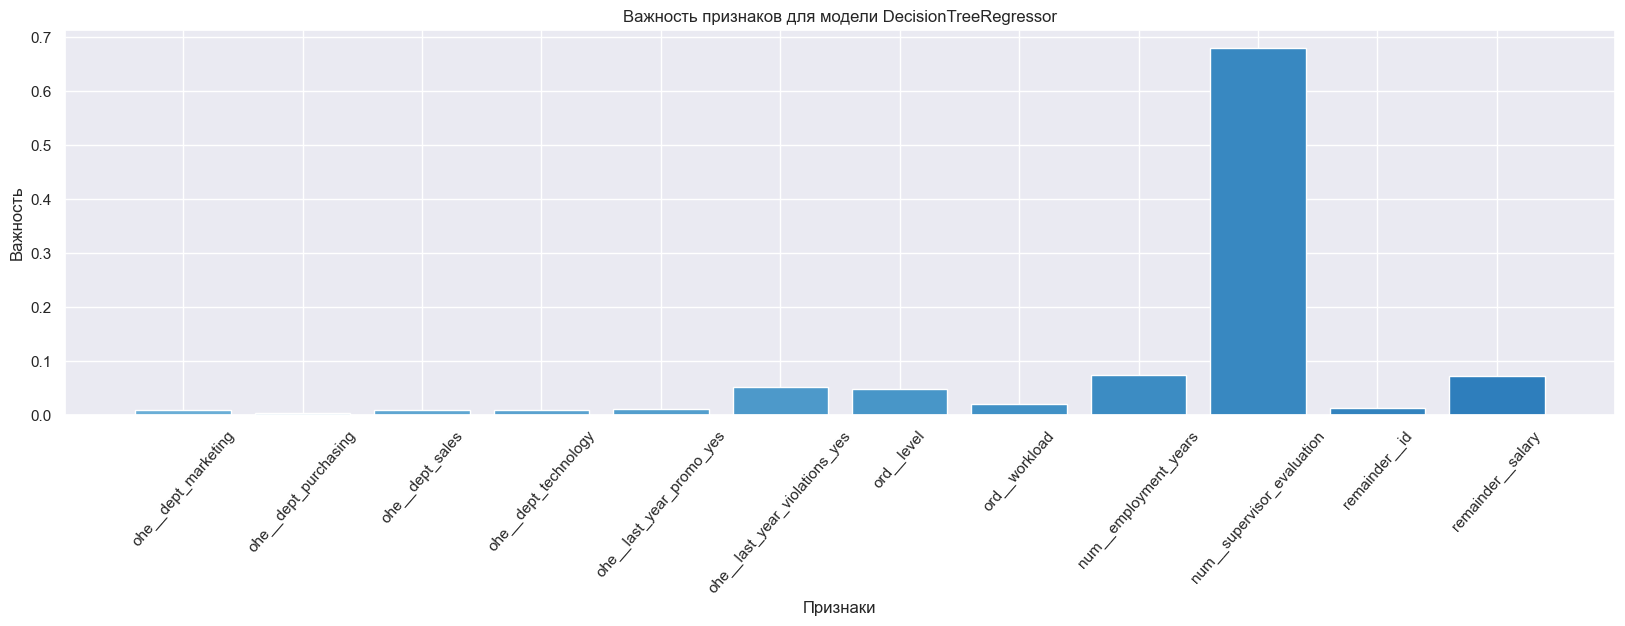

In [102]:
# построим столбчатую диаграмму анализа важности признаков

plt.figure(figsize=(20, 5))
colors = plt.cm.Blues(np.linspace(0.5, 0.7, len(feature_importances)))
plt.bar(range(len(feature_names)), feature_importances, tick_label=feature_names, color=colors)
plt.title('Важность признаков для модели DecisionTreeRegressor')
plt.xlabel('Признаки')
plt.ylabel('Важность')
plt.xticks(rotation=49)
plt.show()

<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

Наиболее важным для модели признаком оказалась оценка работы сотрудника, данная руководителем. Это подтверждает результаты исследовательского анализа — разница этого признака у групп сотрудников с низкой и высокой удовлетворенностью была очень ощутимой. Однако такой результат совершенно не означает, что с помощью более высокой оценки можно поднять удовлетворённость сотрудников. Скорее всего, такая связь вызвана тем, что недовольные сотрудники (как было выяснено ранее) чаще нарушают трудовой договор, возможно, не выполняя должным образом свои обязанности, что провоцирует низкую оценку руководства. С другой стороны, незаслуженно низкая оценка от руководителя может существенно повлиять на удовлетворённость работой, особенно если она влияет на итоговую заработную плату. Следует помнить, что важность признаков не всегда означает причинно-следственную связь, этот анализ лишь указывает на корреляцию с целевой переменной. Чтобы сделать более точные выводы, необходимо проконсультироваться с заказчиком — понять, как происходит процесс оценки сотрудников руководителем, контролируются ли кем-то его результаты, по каким критериям оценивают сотрудника, на что влияет эта оценка и какие меры предпринимаются по отношению к людям, получившим низкую оценку
    
</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Общий вывод
</div>

---

По результатам исследования лучшей оказалась модель `DecisionTreeRegressor` со следующими параметрами:

- `max_depth`: 13
- `max_features`: 13
- `min_samples_leaf`: 3
- `min_samples_split`: 12

SMAPE этой модели при кросс-валидации составила *15.35*. Эта же метрика на тестовой выборке равна *14.41*. Критерий успеха достигнут, на тестовой выборке SMAPE <= 15. `DecisionTreeRegressor` также прошла проверку на адекватность, совершённую с помощью константной модели `DummyRegressor`. Проверка закончилась со следующими результатами:
- метрика SMAPE модели DecisionTreeRegressor на тестовой выборке: `14.361645`
- метрика SMAPE модели DummyRegressor на тестовой выборке: `38.226050`

Успех модели регрессии на основе деревьев решений может обусловлен тем, что в данных содержится много категориальных значений, сам датасет является небольшим, а признаки имеют сложные нелинейные зависимости. Именно с такой задачей хорошо справляется DecisionTreeRegressor

---

С помощью исследовательского анализа данных был определён примерный портрет сотрудника, неудовлетворённого работой в компании: чаще такие сотрудники находятся в отделе продаж, технологий и маркетинга. Они скорее склонны иметь средний уровень загруженности, в отличие от довольных сотрудников, которые чаще имеют либо высокий либо низкий уровень загруженности. Больше половины неудовлетворённых сотрудников работали в компании меньше трёх лет, и преимущественно из этого числа — меньше одного или двух лет. Они реже получали повышение, но чаще нарушали трудовой договор. Руководитель, как правило, оценивает их работу не выше, чем на «тройку». Их средняя зарплата равна 32752 ₽, тогда как у другой группы она равна 35378 ₽. Дополняя этот вывод, анализ важности признаков показал, что наибольшее влияние на целевой признак оказывает оценка работы сотрудника, данная руководителем. Кроме того, на целевой признак заметно влияют длительность работы сотрудника и его зарплата

---

<div style="border: 1px solid rgba(28, 28, 28, 0.2); border-radius: 2px; background-color: rgba(255, 255, 255, 0.8); padding: 10px; font-size: 25px; color: rgba(28, 28, 28, 0.9);">
Задача 2. Предсказание увольнения сотрудника из компании
</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Загрузка и предварительное изучение данных
</div>

---

In [103]:
# применим функцию load_datasets()

datasets_2 = load_datasets(PATHS_2)

Файл train_quit.csv успешно загружен!
Файл test_target_quit.csv успешно загружен!


In [104]:
# сохраним таблицы в переменные с соответствующими им именами

for name, dataset in zip(NAMES_2, datasets_2):
    globals()[name] = dataset

---

In [105]:
# изучим общую информацию о таблице train_quit

get_info(train_quit)

Пять случайных строк таблицы:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
1259,190863,technology,middle,medium,9,no,yes,2,44400,no
3861,450007,purchasing,middle,low,6,no,yes,2,28800,no
3432,498444,sales,junior,medium,1,no,no,4,27600,no
1501,372808,marketing,middle,medium,5,no,no,4,46800,no
846,861487,sales,sinior,medium,10,no,no,3,57600,no


 
Общая информация о таблице:
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
None


In [106]:
# изучим общую информацию о таблице test_target_quit

get_info(test_target_quit)

Пять случайных строк таблицы:


,id,quit
594,761490,yes
995,931914,no
1536,169600,no
55,919955,no
1432,676389,no


 
Общая информация о таблице:
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None


- типы данных в обеих таблицах отображены корректно
- данные соответствуют описанию
- пропуски отсутствуют
- все признаки остались теми же, изменился только целевой

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Предобработка данных
</div>

---

### `train_quit`

In [107]:
# применим функцию preprocess

preprocess(train_quit, 'train_quit')

В таблице train_quit не найдено ни одного пропуска!
В таблице train_quit не найдено ни одного дубликата!


In [108]:
# выведем на экран уникальные значения каждого категориального столбца

hidden_duplicates(train_quit)

Уникальные значения в столбце dept: ['sales' 'purchasing' 'marketing' 'technology' 'hr']
Уникальные значения в столбце level: ['middle' 'junior' 'sinior']
Уникальные значения в столбце workload: ['high' 'medium' 'low']
Уникальные значения в столбце last_year_promo: ['no' 'yes']
Уникальные значения в столбце last_year_violations: ['no' 'yes']
Уникальные значения в столбце quit: ['no' 'yes']


Видим ту же ошибку, что и в `train_data`

In [109]:
# заменим ошибку в столбце level

train_quit['level'].replace('sinior', 'senior', inplace=True)

In [110]:
# проверим результат

print(f"Обновлённый список уникальных значений в столбце level: {train_quit['level'].unique()}")

Обновлённый список уникальных значений в столбце level: ['middle' 'junior' 'senior']


### `test_target_quit`

In [111]:
# применим функцию preprocess

preprocess(test_target_quit, 'test_target_quit')

В таблице test_target_quit не найдено ни одного пропуска!
В таблице test_target_quit не найдено ни одного дубликата!


<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

Предобработка данных завершена. Дубликатов в данных нет, ошибки в значениях столбца устранены; пробелы, пустые строки и NaN отсутствуют
    
</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Исследовательский анализ данных
</div>

---

In [112]:
def twin_hists(data_1, data_2, col, bins, xlabel, title, xticks, label1, label2):
    
    """
    Функция twin_hists выводит на экран две совмещённые гистограммы для одного признака

    Аргументы:
    data_1 (DataFrame) : первый датафрейм
    data_2 (DataFrame) : второй датафрейм
    col (str) : название столбца с признаком
    bins (int) : количество корзин для гистограммы
    xlabel (str) : подпись оси X
    title (str) : название графика
    xticks : числовой диапазон по оси X
    label1 (str) : название первого датафрейма
    label2 (str) : название второго датафрейма
    
    """
    
    sns.set(style='darkgrid', palette='pastel')
    plt.figure(figsize=(20, 5))
    
    sns.histplot(data=data_1, x=col, kde=True, bins=bins, label=label1, color='skyblue')
    sns.histplot(data=data_2, x=col, kde=True, bins=bins, label=label2, color='indianred')
    
    plt.title(title, fontsize=16)
    plt.ylabel('Количество сотрудников')
    plt.xlabel(xlabel)
    plt.legend()
    plt.grid(True)
    plt.xticks(xticks)
    
    plt.show()

In [113]:
def compare_barplots_2(data1, col1, xlabel1, title1, data2, col2, xlabel2, title2):
    
    """
    Функция compare_barplots выводит на экран два столбчатых графика рядом друг с другом

    Аргументы:

    data1 (DataFrame) : первый датафрейм
    col1 (str) : название столбца первого датафрейма
    xlabel1 (str) : подпись оси Х для первого графика
    title1 (str) : название первого графика

    data2 (DataFrame) : второй датафрейм
    col2 (str) : название столбца второго датафрейма
    xlabel2 (str) : подпись оси Х для второго графика
    title2 (str) : название второго графика

    main_title (str): главный заголовок, который будет расположен над обоими графиками
    
    """
    
    sns.set(style='darkgrid')
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))

    for ax, data, col, xlabel, title in zip(
        axes, 
        [data1, data2], 
        [col1, col2], 
        [xlabel1, xlabel2], 
        [title1, title2]
    ):
        percent_data = data[col].value_counts(normalize=True)
        
        percent_data_ = percent_data.reset_index()
        percent_data_.columns = [col, 'percent']

        unique_values = len(percent_data_)
        palette = sns.color_palette('Blues', unique_values)

        sns.barplot(x=col, y='percent', data=percent_data_, hue=col, dodge=False, palette=palette, ax=ax, legend=False)

        for i, p in enumerate(ax.patches):
            ax.text(p.get_x() + p.get_width() / 2., p.get_height(), f"{percent_data_['percent'].iloc[i]:.0%}",
                    fontsize=8, ha='center', va='bottom')

        ax.set_title(title, fontsize=16)
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Процент сотрудников')

    plt.tight_layout() 
    plt.show()

### `job_satisfaction_rate` — добавление признака

In [114]:
# сделаем предсказание на тренировочных данных из train_quit с помощью лучшей модели из предыдущего шага

pred_satisfaction_train = rs_1.predict(train_quit)

In [115]:
# добавим в train_quit получившийся новый признак

train_quit['job_satisfaction_rate'] = pred_satisfaction_train

In [116]:
# оценим результат

get_info(train_quit)

Пять случайных строк таблицы:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
485,706881,technology,junior,medium,3,no,no,3,34800,no,0.520000
600,546410,technology,junior,medium,1,no,yes,4,26400,yes,0.373333
579,297400,sales,junior,medium,4,no,no,5,21600,no,0.630000
538,883753,purchasing,middle,low,5,no,no,3,24000,no,0.581719
2138,785722,marketing,junior,medium,1,no,no,2,22800,yes,0.186000


 
Общая информация о таблице:
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   4000 non-null   object 
 2   level                  4000 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   quit                   4000 non-null   object 
 10  job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(6)
memory usage: 343.9+ KB
None


### `quit`

Предстоит решить задачу бинарной классификации. Для этой задачи будем рассматривать данные в разрезе целевого признака. Для исследовательского анализа используем тренировочную выборку

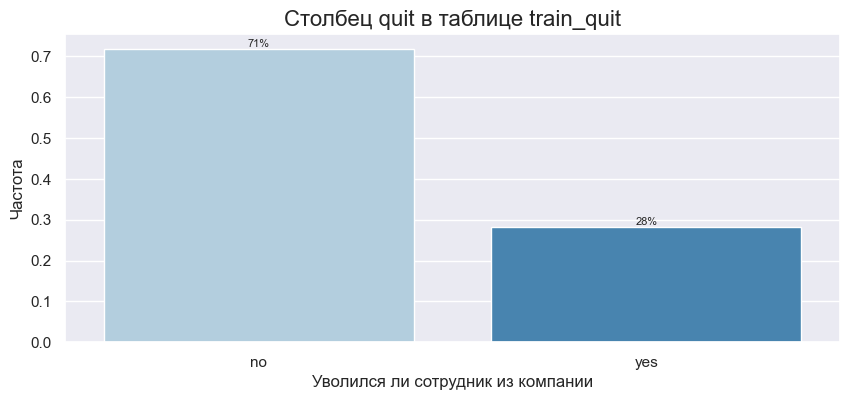

In [117]:
# построим столбчатую диаграмму для столбца quit таблицы train_quit

barplot(
    train_quit, 'quit',
    'Уволился ли сотрудник из компании',
    'Столбец quit в таблице train_quit'
)

In [118]:
# разделим тренировочные данные на две категории по значению целевого признака

train_quit_yes = train_quit.query('quit == "yes"')
train_quit_no = train_quit.query('quit == "no"')

In [119]:
# проверим результат

print('Размер таблицы, содержащей данные об уволившихся сотрудниках:')
print(train_quit_yes.shape)
print(f'Таблица содержит уникальные значения: {train_quit_yes["quit"].unique()}')
print(' ')
print('Размер таблицы, содержащей данные о сотрудниках, которые не уволились:')
print(train_quit_no.shape)
print(f'Таблица содержит уникальные значения: {train_quit_no["quit"].unique()}')

Размер таблицы, содержащей данные об уволившихся сотрудниках:
(1128, 11)
Таблица содержит уникальные значения: ['yes']
 
Размер таблицы, содержащей данные о сотрудниках, которые не уволились:
(2872, 11)
Таблица содержит уникальные значения: ['no']


Видим, что относительно имеющихся данных количество уволившихся сотрудников составило 1128 человек или 28% от общего числа

### `job_satisfaction_rate`

In [120]:
# выведем на экран числовое распределение данных

describe(train_quit_yes, 'job_satisfaction_rate', 'train_quit_yes')
print(' ')
describe(train_quit_no, 'job_satisfaction_rate', 'train_quit_no')

Числовое описание столбца job_satisfaction_rate таблицы train_quit_yes:
 
count    1128.000000
mean        0.402749
std         0.188470
min         0.060000
25%         0.250000
50%         0.369091
75%         0.529091
max         0.898889
Name: job_satisfaction_rate, dtype: float64
 
Числовое описание столбца job_satisfaction_rate таблицы train_quit_no:
 
count    2872.000000
mean        0.591125
std         0.202409
min         0.071000
25%         0.430577
50%         0.647500
75%         0.780909
max         0.964286
Name: job_satisfaction_rate, dtype: float64


У уволившихся сотрудников уровень удовлетворённости работой в среднем составил 0.40, а по медиане — 0.37, у оставшихся, в среднем, удовлетворённость оценивается в 0.59, по медиане — 0.64. Среди уволившихся максимальным уровнем удовлетворённости являлось значение в 0.89, среди оставшихся оно равно 0.96

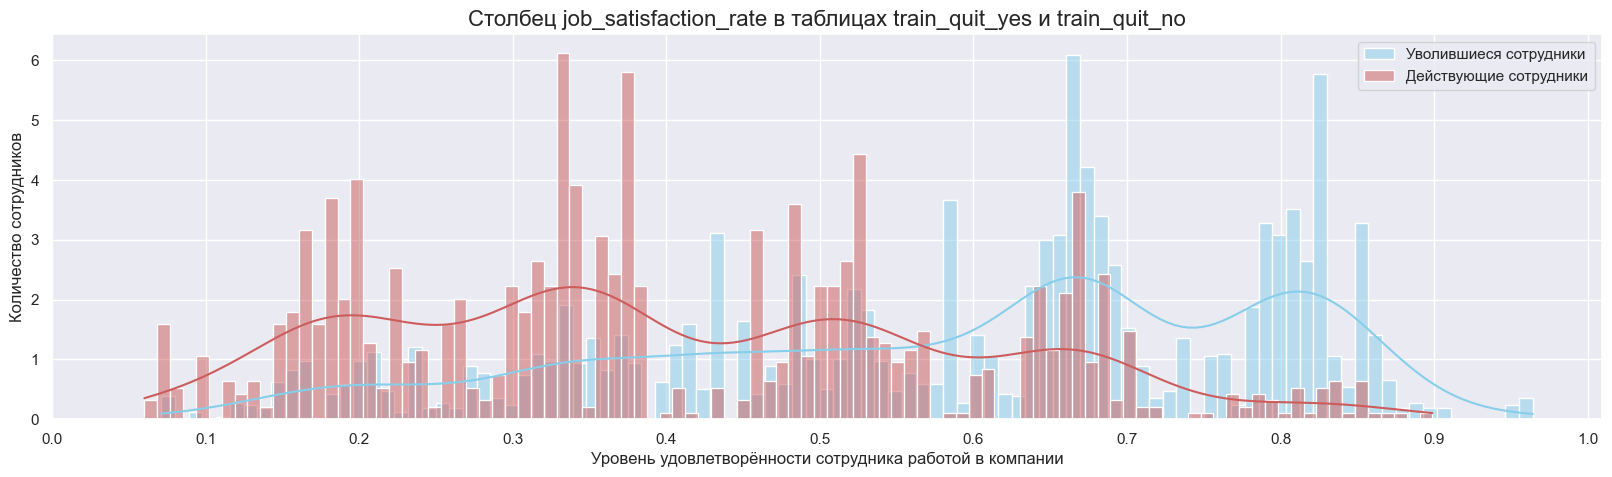

In [121]:
# построим гистограммы для таблиц train_quit_no и train_quit_yes

xticks = np.arange(0, 1.1, 0.1)
twin_hists_normalized(
    train_quit_no, train_quit_yes, 'job_satisfaction_rate', 100, 'Уровень удовлетворённости сотрудника работой в компании',
    'Столбец job_satisfaction_rate в таблицах train_quit_yes и train_quit_no', xticks,
    'Уволившиеся сотрудники', 'Действующие сотрудники'
)

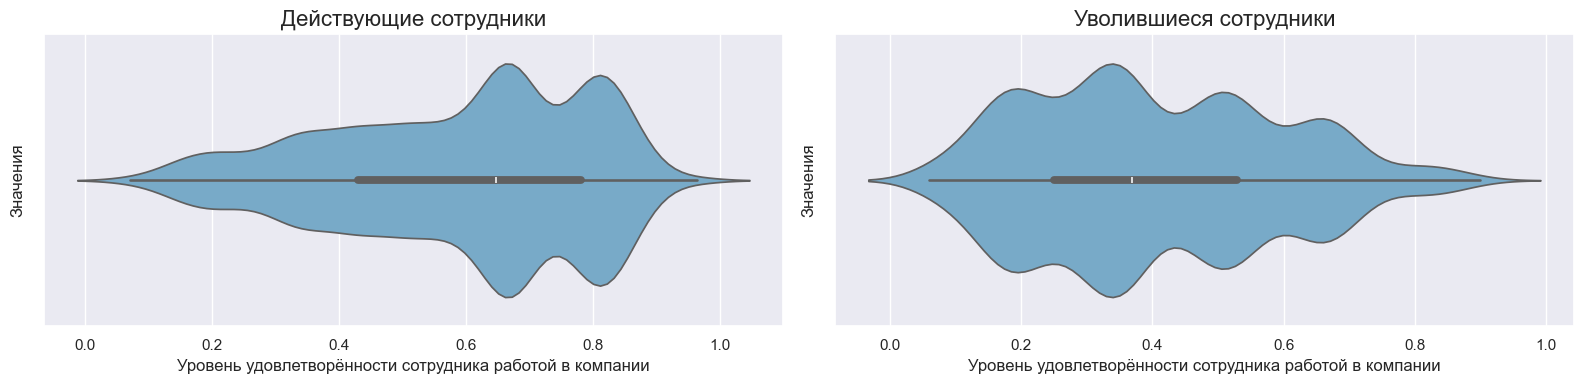

In [122]:
# построим скрипичные диаграммы для таблиц train_quit_no и train_quit_yes

compare_violins(
    train_quit_no, 'job_satisfaction_rate', 'Действующие сотрудники', 'Уровень удовлетворённости сотрудника работой в компании',
    train_quit_yes, 'job_satisfaction_rate', 'Уволившиеся сотрудники', 'Уровень удовлетворённости сотрудника работой в компании'   
)

И на гистограмме, и на скрипичной диаграмме отчётливо видно, что в сегменте уволившихся сотрудников основная масса наблюдений находится в диапазоне от 0.2 до 0.6, что значительно ниже, чем у тех людей, которые остались работать в компании

### `dept`

In [123]:
# выведем на экран числовое распределение данных

value_counts(train_quit_yes, 'dept', 'train_quit_yes')
print(' ')
value_counts(train_quit_no, 'dept', 'train_quit_no')

Распределение данных в столбце dept таблицы train_quit_yes:
 
dept
sales         407
technology    276
purchasing    166
marketing     163
hr            116
Name: count, dtype: int64
 
Распределение данных в столбце dept таблицы train_quit_no:
 
dept
sales         1031
technology     652
purchasing     422
marketing      419
hr             348
Name: count, dtype: int64


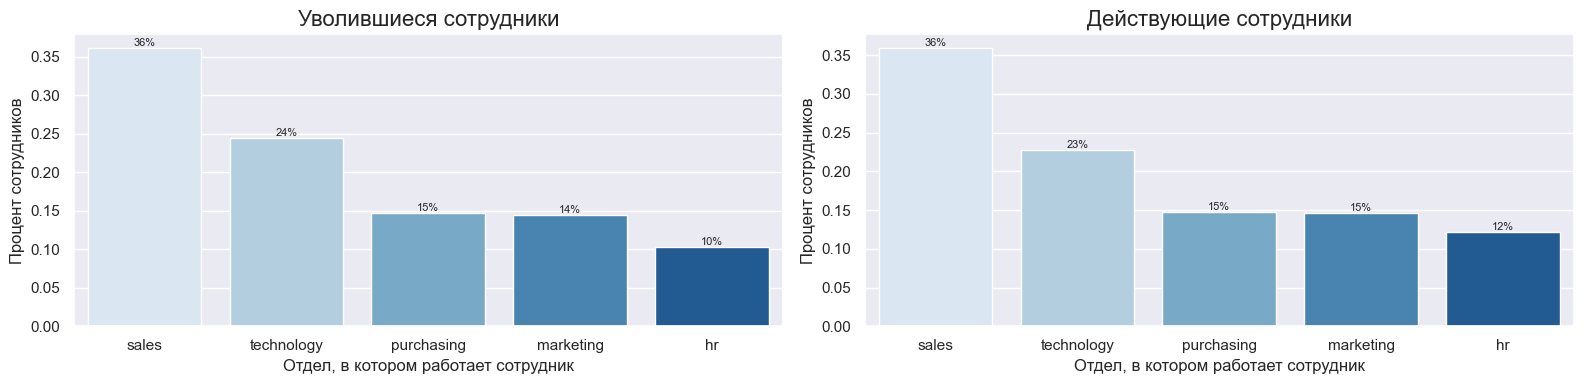

In [124]:
# построим пару столбчатых диаграмм для таблиц train_quit_yes и train_quit_no

compare_barplots_2(
    train_quit_yes, 'dept', 'Отдел, в котором работает сотрудник', 'Уволившиеся сотрудники',
    train_quit_no, 'dept', 'Отдел, в котором работает сотрудник', 'Действующие сотрудники',
)

Значимых отличий в распределениях данных не наблюдается. Согласно этим графикам, увольнения ***не*** происходят преимущественно в каком-то определённом отделе компании, хотя в группе уволившихся сотрудники на 1% чаще работали в отделе технологий и на 1% и 2% реже в отделе маркетинга и HR соответственно

### `level`

In [125]:
# выведем на экран числовое распределение данных

value_counts(train_quit_yes, 'level', 'train_quit_yes')
print(' ')
value_counts(train_quit_no, 'level', 'train_quit_no')

Распределение данных в столбце level таблицы train_quit_yes:
 
level
junior    1003
middle     108
senior      17
Name: count, dtype: int64
 
Распределение данных в столбце level таблицы train_quit_no:
 
level
middle    1586
junior     946
senior     340
Name: count, dtype: int64


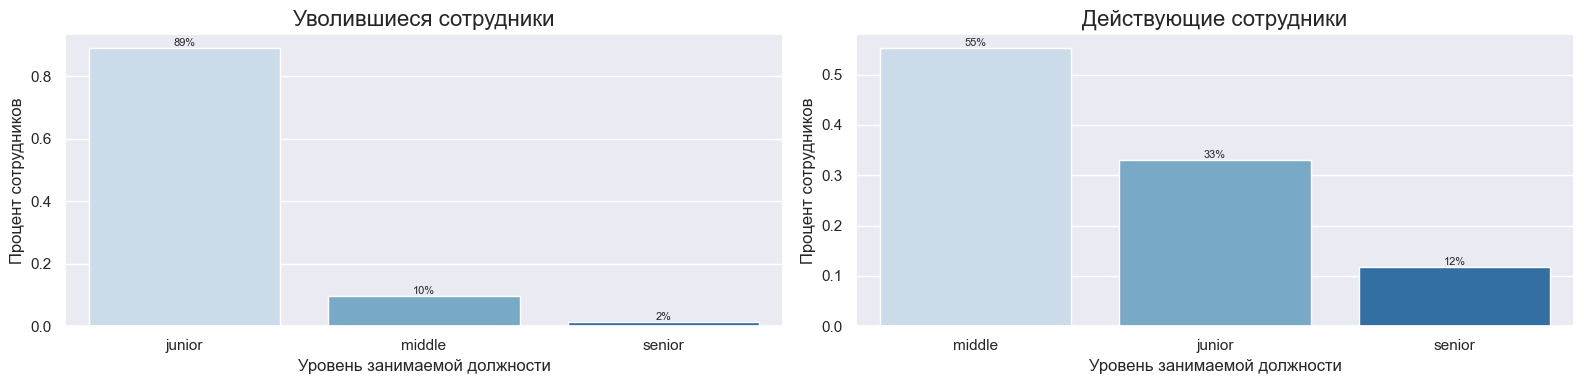

In [126]:
# построим пару столбчатых диаграмм для таблиц train_quit_yes и train_quit_no

compare_barplots_2(
    train_quit_yes, 'level', 'Уровень занимаемой должности', 'Уволившиеся сотрудники',
    train_quit_no, 'level', 'Уровень занимаемой должности', 'Действующие сотрудники',
)

Меньше всего увольняются наиболее опытные сотрудники — сеньоры. Миддлы также являются очень стабильной группой сотрудников, а наибольшая текучка происходит среди самых младших сотрудников. Если посмотреть на числовое распределение данных, можно сделать вывод, что, если общее количество джуниоров во всех данных составляет 1949 человек (практически половина всех сотрудников), то увольняются из этого числа около 51%. А если взглянуть на процентность от общего числа всех уволившихся (1128 человек), то джуниоров из них аж 88%! Конечно, это не статистические данные, а подсчёт уволившихся в определённой компании с помощью определённых ограниченных данных, но, тем не менее, это позволяет сделать вывод, что джуниоры являются основной группой риска. Это может быть связано с самыми разными причинами, от разочарования компанией до разочарования профессией в целом

### `workload`

In [127]:
# выведем на экран числовое распределение данных

value_counts(train_quit_yes, 'workload', 'train_quit_yes')
print(' ')
value_counts(train_quit_no, 'workload', 'train_quit_no')

Распределение данных в столбце workload таблицы train_quit_yes:
 
workload
low       519
medium    488
high      121
Name: count, dtype: int64
 
Распределение данных в столбце workload таблицы train_quit_no:
 
workload
medium    1630
low        689
high       553
Name: count, dtype: int64


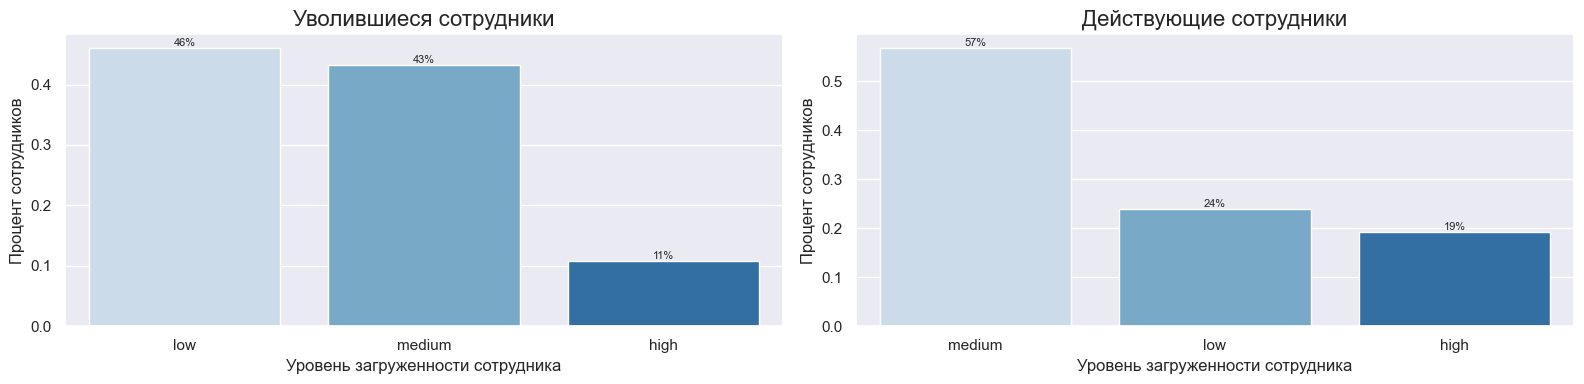

In [128]:
# построим пару столбчатых диаграмм для таблиц train_quit_yes и train_quit_no

compare_barplots_2(
    train_quit_yes, 'workload', 'Уровень загруженности сотрудника', 'Уволившиеся сотрудники',
    train_quit_no, 'workload', 'Уровень загруженности сотрудника', 'Действующие сотрудники',
)

Среди уволившихся самые частые показатели загруженности — низкий и средний (46% и 43% соответственно)

### `employment_years`

In [129]:
# выведем на экран числовое распределение данных

describe(train_quit_yes, 'employment_years', 'train_quit_yes')
print(' ')
describe(train_quit_no, 'employment_years', 'train_quit_no')

Числовое описание столбца employment_years таблицы train_quit_yes:
 
count    1128.000000
mean        1.844858
std         1.274920
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        10.000000
Name: employment_years, dtype: float64
 
Числовое описание столбца employment_years таблицы train_quit_no:
 
count    2872.000000
mean        4.430710
std         2.544635
min         1.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


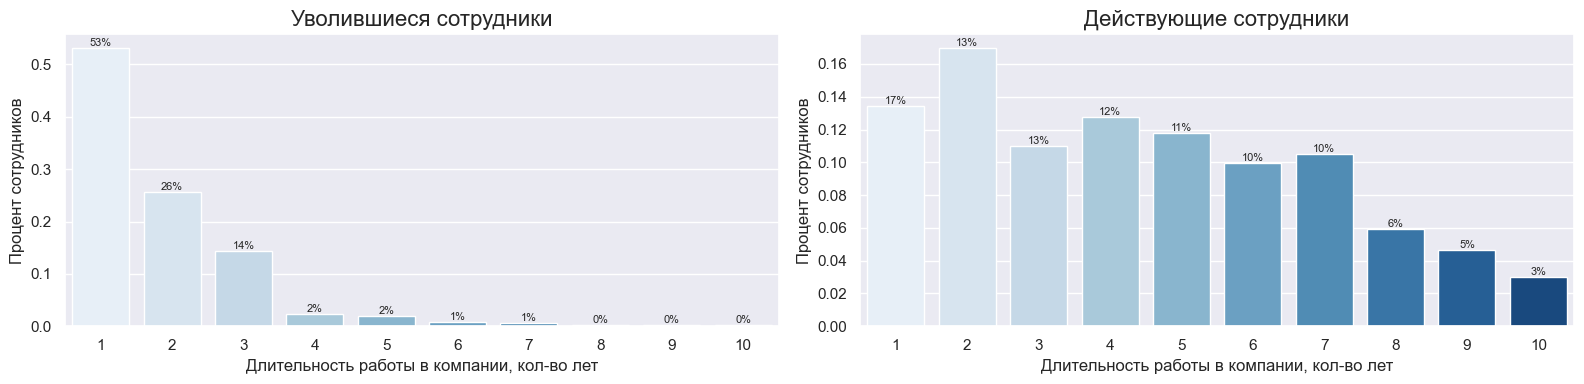

In [130]:
# построим пару столбчатых диаграмм для таблиц train_quit_yes и train_quit_no

compare_barplots_2(
    train_quit_yes, 'employment_years', 'Длительность работы в компании, кол-во лет', 'Уволившиеся сотрудники',
    train_quit_no, 'employment_years', 'Длительность работы в компании, кол-во лет', 'Действующие сотрудники',
)

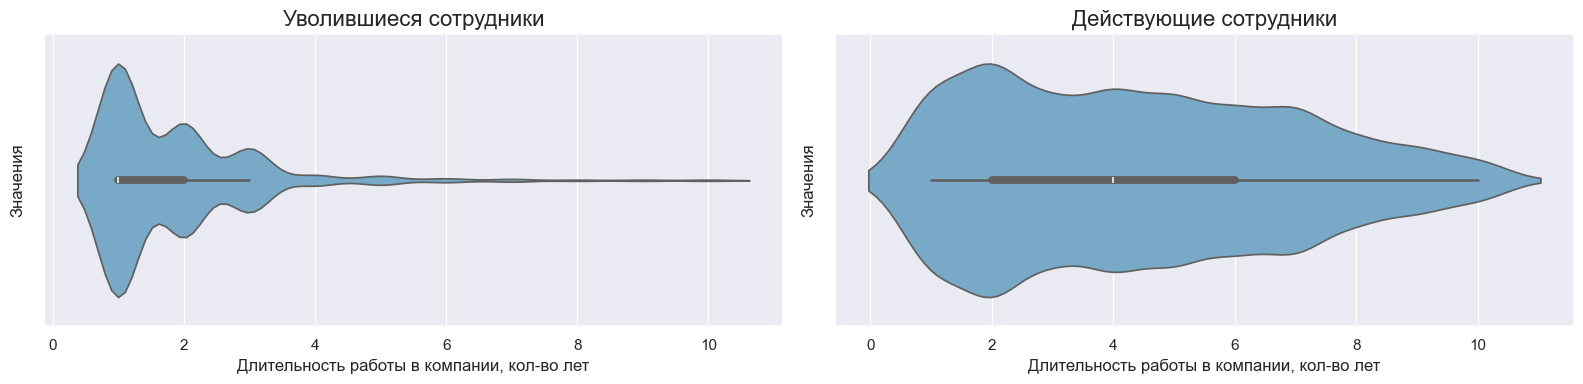

In [131]:
# построим пару скрипичных диаграмм для таблиц train_quit_yes и train_quit_no

compare_violins(
    train_quit_yes, 'employment_years', 'Уволившиеся сотрудники', 'Длительность работы в компании, кол-во лет',
    train_quit_no, 'employment_years', 'Действующие сотрудники', 'Длительность работы в компании, кол-во лет'   
)

Снова находим подтверждение предыдущим выводам: увольняются те сотрудники, которые проработали в компании меньше трёх лет, и подавляющее большинство из них (75% данных, третий квартиль) уволились в течение одного-двух лет после трудоустройства

### `last_year_promo`

In [132]:
# выведем на экран числовое распределение данных

value_counts(train_quit_yes, 'last_year_promo', 'train_quit_yes')
print(' ')
value_counts(train_quit_no, 'last_year_promo', 'train_quit_yes')

Распределение данных в столбце last_year_promo таблицы train_quit_yes:
 
last_year_promo
no     1127
yes       1
Name: count, dtype: int64
 
Распределение данных в столбце last_year_promo таблицы train_quit_yes:
 
last_year_promo
no     2760
yes     112
Name: count, dtype: int64


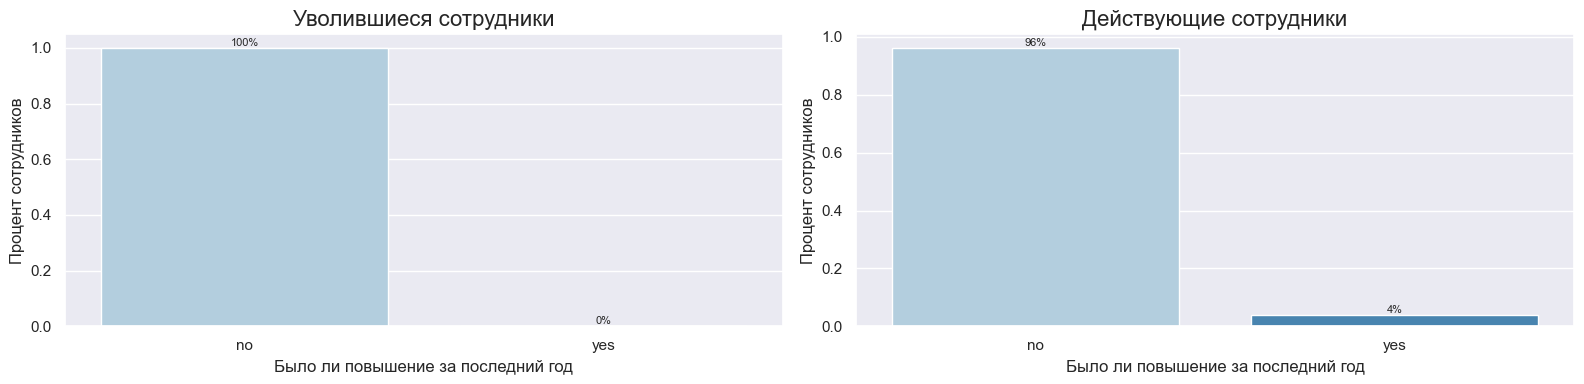

In [133]:
# построим пару столбчатых диаграмм для таблиц train_quit_yes и train_quit_no

compare_barplots_2(
    train_quit_yes, 'last_year_promo', 'Было ли повышение за последний год', 'Уволившиеся сотрудники',
    train_quit_no, 'last_year_promo', 'Было ли повышение за последний год', 'Действующие сотрудники'
)

Лишь один человек, получивший повышение за последний год, впоследствии решил уволиться. Влияние повышения на последующее увольнение хоть и не слишком сильное, но то, что оно существует — отрицать нельзя. Так, среди уволившихся повышение ***не*** получили на 4% людей больше, чем среди тех, кто остался

### `last_year_violations`

In [134]:
# выведем на экран числовое распределение данных

value_counts(train_quit_yes, 'last_year_violations', 'train_quit_yes')
print(' ')
value_counts(train_quit_no, 'last_year_violations', 'train_quit_no')

Распределение данных в столбце last_year_violations таблицы train_quit_yes:
 
last_year_violations
no     900
yes    228
Name: count, dtype: int64
 
Распределение данных в столбце last_year_violations таблицы train_quit_no:
 
last_year_violations
no     2555
yes     317
Name: count, dtype: int64


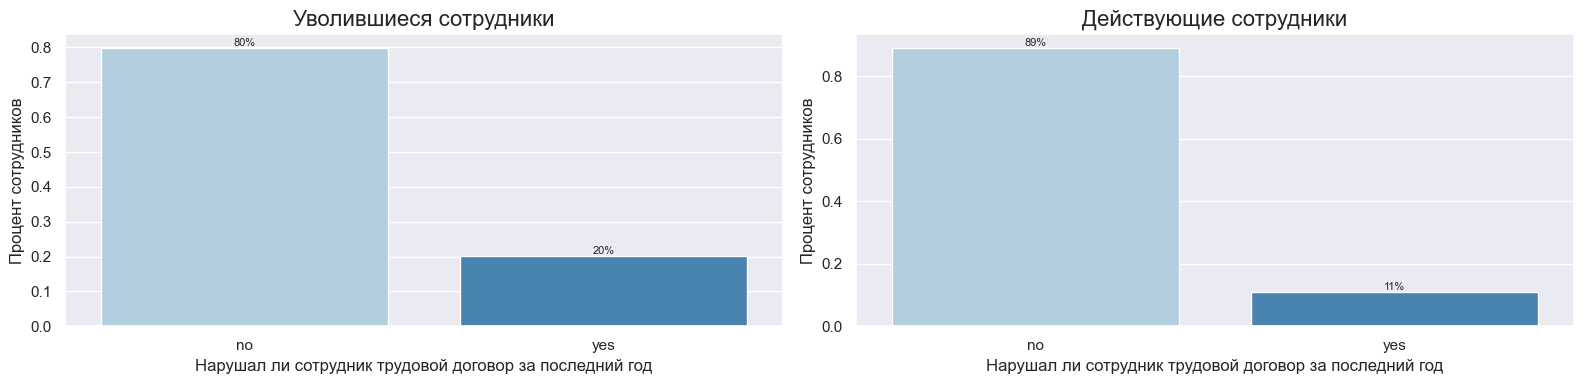

In [135]:
# построим пару столбчатых диаграмм для таблиц train_quit_yes и train_quit_no

compare_barplots_2(
    train_quit_yes, 'last_year_violations', 'Нарушал ли сотрудник трудовой договор за последний год', 'Уволившиеся сотрудники',
    train_quit_no, 'last_year_violations', 'Нарушал ли сотрудник трудовой договор за последний год', 'Действующие сотрудники'
)

Среди тех, кто уволился из компании, процент нарушивших трудовой договор на 9% больше, чем среди действующих сотрудников

### `supervisor_evaluation`

In [136]:
# выведем на экран числовое распределение данных

value_counts(train_quit_yes, 'supervisor_evaluation', 'train_quit_yes')
print(' ')
value_counts(train_quit_no, 'supervisor_evaluation', 'train_quit_no')

Распределение данных в столбце supervisor_evaluation таблицы train_quit_yes:
 
supervisor_evaluation
3    523
4    286
2    164
1     95
5     60
Name: count, dtype: int64
 
Распределение данных в столбце supervisor_evaluation таблицы train_quit_no:
 
supervisor_evaluation
4    1368
3     710
5     460
2     227
1     107
Name: count, dtype: int64


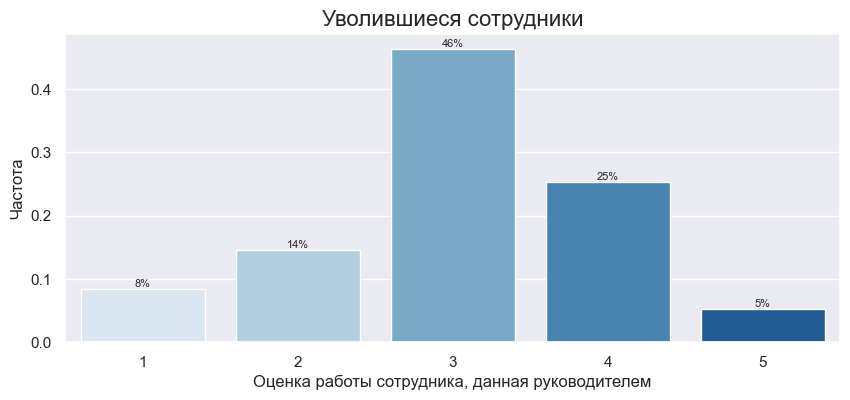

In [137]:
# выведем столбчатую диаграмму для столбца supervisor_evaluation в таблице train_quit_yes

barplot(train_quit_yes, 'supervisor_evaluation', 'Оценка работы сотрудника, данная руководителем', 'Уволившиеся сотрудники')

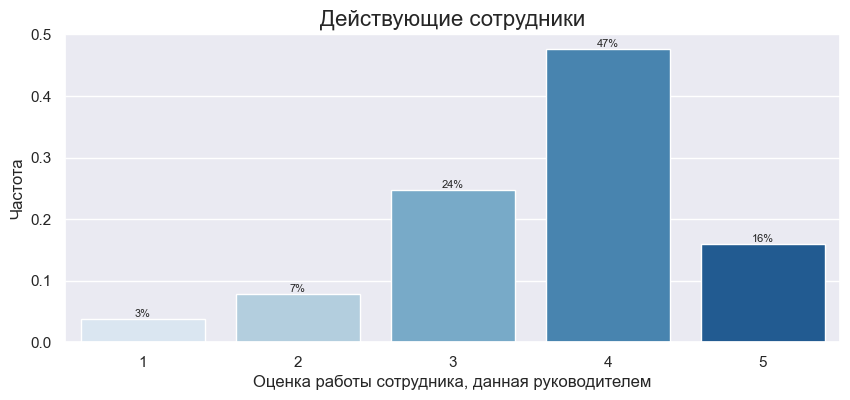

In [138]:
# выведем столбчатую диаграмму для столбца supervisor_evaluation в таблице train_quit_yes

barplot(train_quit_no, 'supervisor_evaluation', 'Оценка работы сотрудника, данная руководителем', 'Действующие сотрудники')

Среди уволившихся 68% сотрудников получали оценки три и ниже. Действущие же сотрудники, напротив, в 67% получали оценки три и выше

### `salary`

In [139]:
# выведем на экран числовое распределение данных

describe(train_quit_yes, 'salary', 'train_quit_yes')
print(' ')
describe(train_quit_no, 'salary', 'train_quit_no')

Числовое описание столбца salary таблицы train_quit_yes:
 
count     1128.000000
mean     23885.106383
std       9351.599505
min      12000.000000
25%      16800.000000
50%      22800.000000
75%      27600.000000
max      79200.000000
Name: salary, dtype: float64
 
Числовое описание столбца salary таблицы train_quit_no:
 
count     2872.000000
mean     37702.228412
std      15218.977339
min      12000.000000
25%      25200.000000
50%      34800.000000
75%      46800.000000
max      96000.000000
Name: salary, dtype: float64


Средняя зарплата среди уволившихся сотрудников составила 23 тысячи 885 рублей, по медиане — 22 тысячи 800 рублей, а максимальное значение зарплаты не превышает 79 тысяч 200 рублей. 75% данных по правую сторону занимают сотрудники с зарплатой до 27 тысяч 600 рублей.

Среди тех, кто остался, средняя зарплата составляет 37 тысяч 702 рубля, по медиане — 34 тысячи 800 рублей, максимальное значение — 96 тысяч рублей (является максимальным и для всего несегментированного набора данных), а третий квартиль отделяет тех сотрудников, которые зарабатывают 46 тысяч 800 рублей и меньше

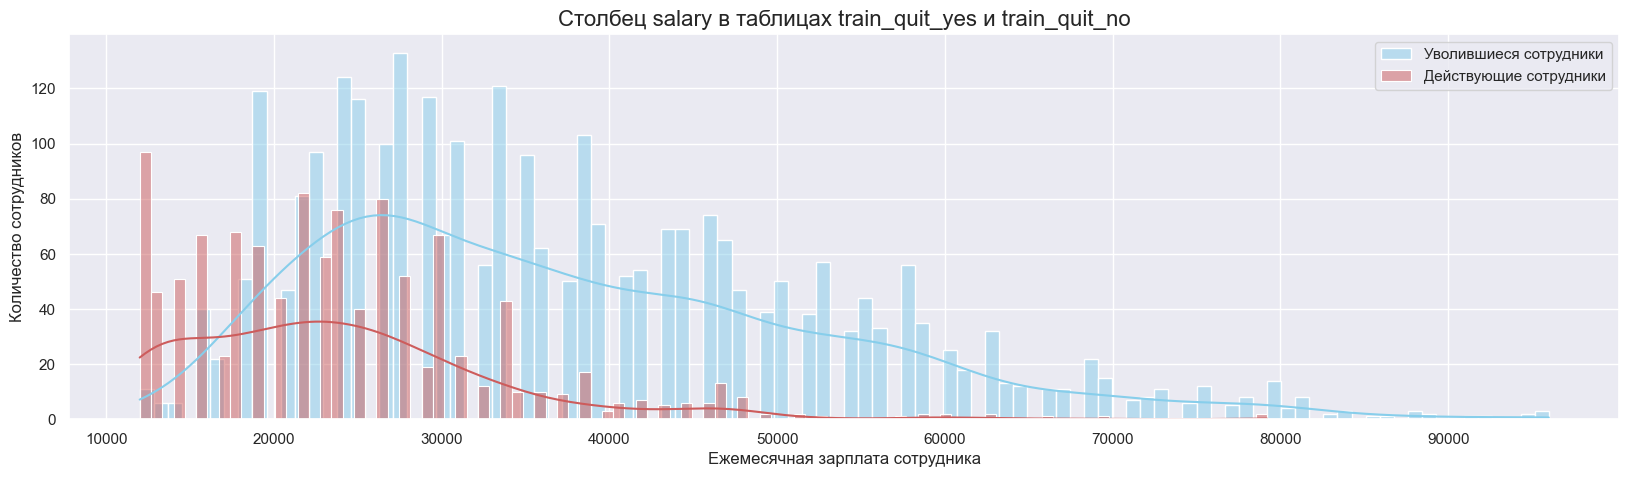

In [140]:
# построим гистограммы для таблиц train_quit_no и train_quit_yes

twin_hists(
    train_quit_no, train_quit_yes, 'salary', 100, 'Ежемесячная зарплата сотрудника',
    'Столбец salary в таблицах train_quit_yes и train_quit_no', range(10000, 100000, 10000),
    'Уволившиеся сотрудники', 'Действующие сотрудники'
)

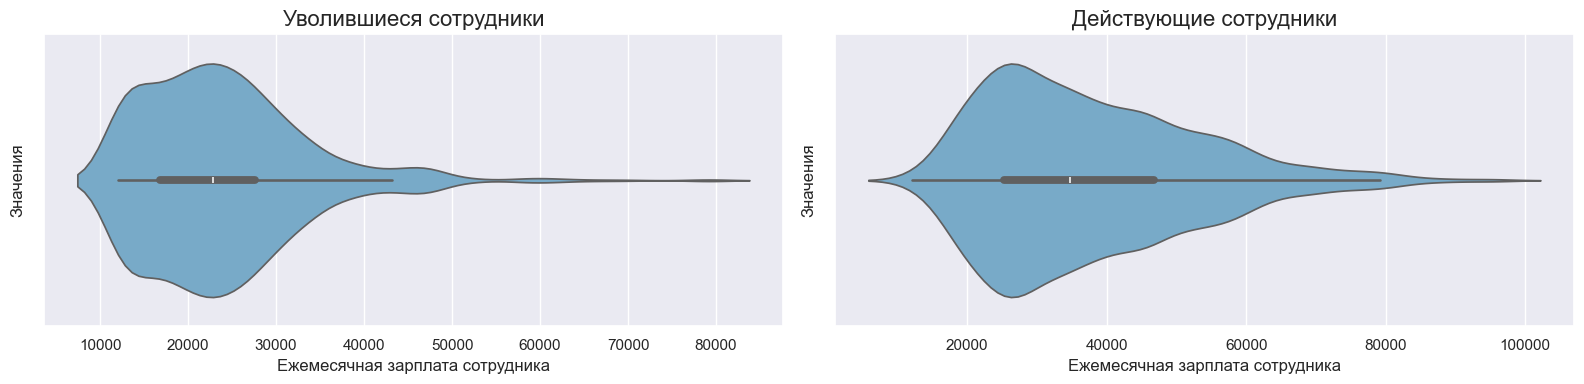

In [141]:
# построим пару скрипичных диаграмм для таблиц train_quit_yes и train_quit_no

compare_violins(
    train_quit_yes, 'salary', 'Уволившиеся сотрудники', 'Ежемесячная зарплата сотрудника',
    train_quit_no, 'salary', 'Действующие сотрудники', 'Ежемесячная зарплата сотрудника'   
)

Основное количество данных об уволившихся сотрудниках сосредоточено в диапазоне от минимума до примерно 50 тысяч рублей. То есть, сотрудники, которые получают зарплату выше этой суммы — это, скорее всего, какие-то особые единичные случаи, например, люди, которые нашли место работы получше или ушли из компании по личным причинам. В данных об оставшихся сотрудниках график зарплаты нисходит в правую сторону более плавно. Всё же высокие значения зарплаты у уволившихся выбросами считать нельзя. Модель должна учитывать этот опыт в предсказании увольнения сотрудников, даже если человек получает хорошую зарплату. И, опять же, графики говорят нам о том, что чаще увольняются сотрудники с более низкой зарплатой

### `job_satisfaction_rate` — сравнение по `quit` на тестовой выборке

Таблицы `test_target_quit` и `test_data` принадлежат тестовой выборке: в первой содержится целевой признак второй задачи, а в другой — все входные и целевой признак из первой задачи. Объединим их

In [142]:
# объединим данные

test_job_quit = test_data.merge(test_target_quit, on='id')

In [143]:
# проверим результат

get_info(test_job_quit)

Пять случайных строк таблицы:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
1900,677509,sales,junior,medium,1,no,no,3,20400,0.18,yes
28,834337,marketing,junior,low,1,no,no,3,16800,0.49,yes
397,634763,sales,middle,low,7,no,no,4,19200,0.64,no
1566,497886,marketing,junior,medium,3,no,no,2,22800,0.39,yes
735,454395,sales,middle,high,8,no,no,4,52800,0.75,no


 
Общая информация о таблице:
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1997 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               1999 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
 10  quit                   2000 non-null   object 
dtypes: float64(1), int64(4), object(6)
memory usage: 172.0+ KB
None


In [144]:
# разделим тестовые данные на две категории по значению целевого признака текущей задачи

test_job_quit_yes = test_job_quit.query('quit == "yes"')
test_job_quit_no = test_job_quit.query('quit == "no"')

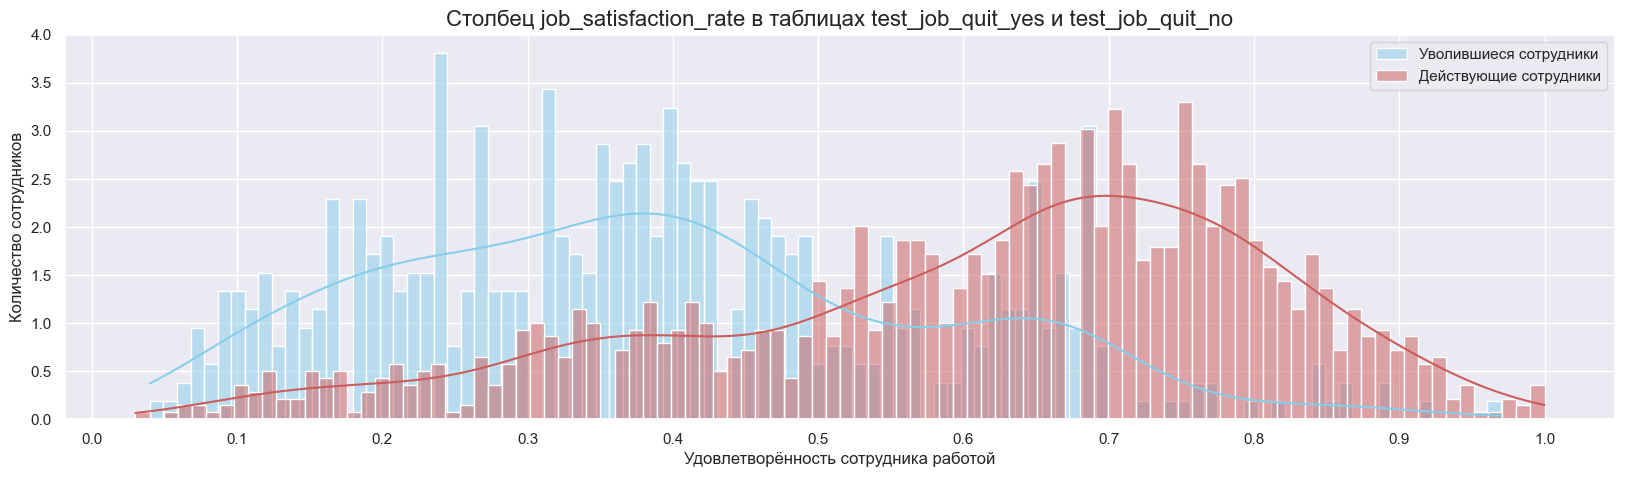

In [145]:
# построим пару гистограмм для таблиц test_job_quit_yes и test_job_quit_no

xticks = np.arange(0, 1.1, 0.1)
twin_hists_normalized(
    test_job_quit_yes, test_job_quit_no, 'job_satisfaction_rate', 100, 'Удовлетворённость сотрудника работой',
    'Столбец job_satisfaction_rate в таблицах test_job_quit_yes и test_job_quit_no', xticks,
    'Уволившиеся сотрудники', 'Действующие сотрудники'
)

Действительно, удовлетворённость сильно влияет на целевой признак. Среди сотрудников, которые остались в компании, удовлетворённость гораздо выше

<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">
    
Исследовательский анализ завершён. Признаки подробны исследованы, данные не содержат выбросов и аномалий, выглядят адекватно и реалистично
    
</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Корреляционный анализ данных
</div>

---

In [146]:
# избавимся от столбца id, сделав его индексом

train_quit_corr = train_quit.set_index('id')

In [147]:
# создадим список с наименованиями непрерывных признаков

interval_cols = ['salary', 'job_satisfaction_rate']

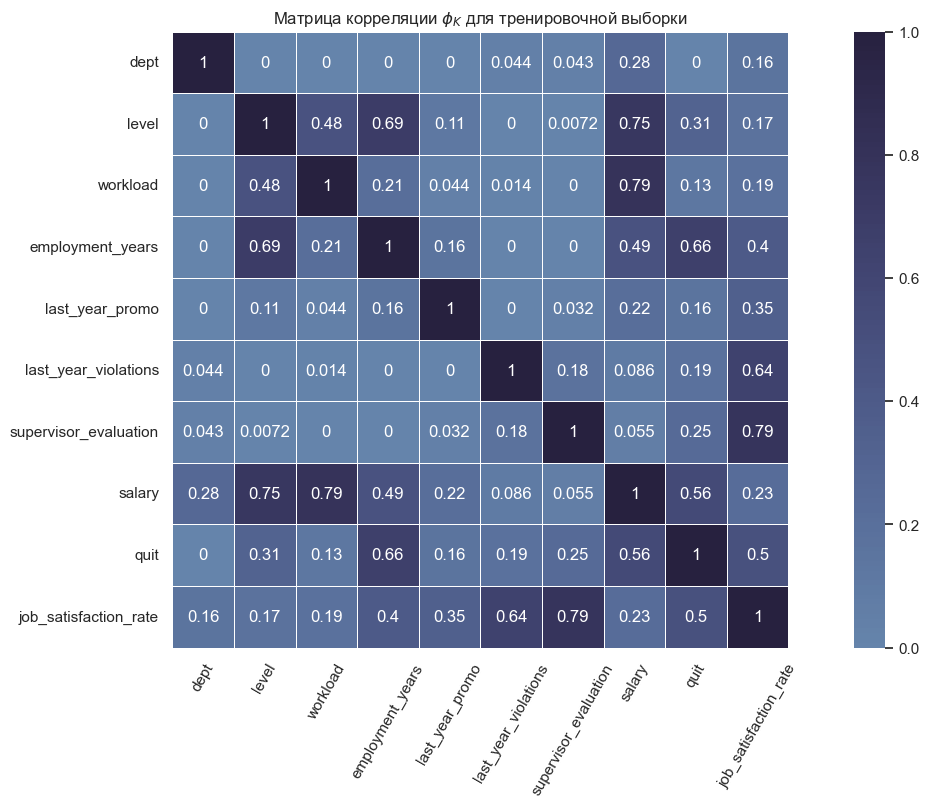

In [148]:
# построим матрицу корреляции для тренировочной выборки

phik(train_quit_corr, interval_cols, 'Матрица корреляции $\phi_K$ для тренировочной выборки')

<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">
    
Видим, что целевой признак имеет некоторую связь с такими признаками, как опытность, количество лет в компании (возможно, такие люди, набравшись опыта, уходят на поиски новых возможностей), оценка работы руководителем, зарплата и удовлетворённость работой. Сильнее всего на увольнение, согласно этой матрице, влияют зарплата, количество проведённых с компанией лет и удовлетворённость сотрудника. Основные взаимосвязи в данных остались такими же, новых закономерностей между входными признаками тут нет, как и мультиколлинеарности

</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Подготовка данных к обучению
</div>

---

In [149]:
def train_test_size(X_train, X_test, y_train, y_test):
                                    
    """
    Функция train_test_size выводит на экран размерность разделённых на выборки данных
    
    Аргументы:
    X_train (DataFrame) : входные признаки тренировочной выборки
    X_test (DataFrame) : входные признаки тестовой выборки
    y_train (Series) : целевой признак тренировочной выборки
    y_test (Series) : целевой признак тестовой выборки
    
    """

    print('Тренировочная выборка')
    print(f'Размерность матрицы со входными признаками: {X_train.shape}')
    print(f'Размерность матрицы с целевым признаком: {y_train.shape}')
    print(' ')
    print('Тестовая выборка')
    print(f'Размерность матрицы со входными признаками: {X_test.shape}')
    print(f'Размерность матрицы с целевым признаком: {y_test.shape}')

---

In [150]:
# создадим новую переменную test_quit, в которой сохраним тестовые данные с новым целевым признаком

test_quit = test_features.copy()

In [151]:
# добавим в test_quit столбец с предсказанными значениями из предыдущей задачи

test_quit['job_satisfaction_rate'] = pred_1

In [152]:
# проверим результат

get_info(test_quit)

Пять случайных строк таблицы:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
702,314842,marketing,middle,medium,10,no,no,2,36000,0.366471
1430,616479,hr,junior,medium,1,no,no,4,31200,0.680256
1492,651259,sales,junior,low,2,no,no,5,12000,0.653571
49,783127,sales,middle,high,5,no,no,4,48000,0.677059
1351,650909,sales,middle,high,7,no,no,1,45600,0.349167


 
Общая информация о таблице:
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1997 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               1999 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 156.4+ KB
None


In [153]:
# упорядочим train_quit, test_quit и test_target_quit по возрастанию id

train_quit = train_quit.sort_values(by='id', ascending=True)
test_quit = test_quit.sort_values(by='id', ascending=True)
test_target_quit = test_target_quit.sort_values(by='id', ascending=True)

In [154]:
# в тренировочных данных сделаем столбец id индексом

train_quit = train_quit.set_index('id')

In [155]:
# проверим тренировочные данные на наличие дубликатов

print(f'Дубликатов обнаружено в таблице train_quit: {train_quit.duplicated().sum()}')

Дубликатов обнаружено в таблице train_quit: 1071


In [156]:
# удалим найденные дубликаты

train_quit = train_quit.drop_duplicates()

In [157]:
# проверим результат

print(f'Дубликатов обнаружено в таблице train_quit: {train_quit.duplicated().sum()}')

Дубликатов обнаружено в таблице train_quit: 0


In [158]:
# переименуем целевой и входные признаки тренировочной и тестовой выборок

X_train = train_quit.drop('quit', axis=1)
y_train = train_quit['quit']

X_test = test_quit.drop('id', axis=1)
y_test = test_target_quit.set_index('id')

In [159]:
# проверим размерность получившихся выборок

train_test_size(X_test, X_train, y_test, y_train)

Тренировочная выборка
Размерность матрицы со входными признаками: (2000, 9)
Размерность матрицы с целевым признаком: (2000, 1)
 
Тестовая выборка
Размерность матрицы со входными признаками: (2929, 9)
Размерность матрицы с целевым признаком: (2929,)


---

In [160]:
# запишем признаки в переменные в соответствии с выбранным для них методом кодирования

ord_cols_2 = ['level', 'workload']
ohe_cols_2 = ['dept', 'last_year_promo', 'last_year_violations']
num_cols_2 = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']
label_cols_2 = ['quit']

In [161]:
# закодируем целевой признак с помощью LabelEncoder

label_encoder = LabelEncoder()
encoded_y_train = label_encoder.fit_transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

C:\Users\User_\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [162]:
# OneHotEncoder

ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe',
            SimpleImputer(strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='error')
        )
    ]
)

In [163]:
# OrdinalEncoder

ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord',
             SimpleImputer(strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high'],
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [164]:
# ColumnTransformer

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_cols),
        ('ord', ord_pipe, ord_cols),
        ('num', StandardScaler(), num_cols)
    ],
    remainder='passthrough'
)

In [165]:
# объединение шагов в итоговом пайплайне

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

Этот пайплайн аналогичен тому, что был создан для предыдущей задачи. В качестве базовой модели выбрана `DecisionTreeClassifier`
    
</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Обучение моделей
</div>

---

In [166]:
# зададим параметры, которые будут перебираться для поиска лучших значений

param_grid_2 = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__max_features': range(2, 20),
        'models__min_samples_leaf': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': [0.1, 1, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': [3, 5, 7],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

Для этой задачи были выбраны такие модели, как `DecisionTreeClassifier`, `LogisticRegression` и `KNeighborsClassifier`. Эти модели хорошо справляются с обработкой категориальных признаков и отлично подходят для задач бинарной классификации

In [167]:
# инициализируем модель подбора гиперпараметров

rs_2 = RandomizedSearchCV(
    pipe_final,
    param_grid_2,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE)

In [168]:
# запустим подбор гиперпараметров

rs_2.fit(X_train, encoded_y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first'))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer_before_ord',
                                                                                                Sim...
                                                               'passthrough']},
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': [0.1, 1, 10],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': [3, 5, 7],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [169]:
# выведем на экран лучшую модель и её параметры

print('Лучшая модель и её параметры:')
print(' ')
print(rs_2.best_estimator_)

Лучшая модель и её параметры:
 
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent...
                                 

In [170]:
# выведем на экран метрику SMAPE получившейся модели

print('Метрика ROC-AUC при кросс-валидации:', rs_2.best_score_)

Метрика ROC-AUC при кросс-валидации: 0.9007593348006822


In [171]:
# сделаем предсказание на тестовой выборке

pred_quit = rs_2.predict(X_test)

In [172]:
# посчитаем метрику ROC-AUC на тестовой выборке

probas = rs_2.predict_proba(X_test)
probas_one = probas[:, 1]
decision_tree_roc_auc = roc_auc_score(y_test, probas_one)

print(f'Метрика ROC-AUC на тестовой выборке: {decision_tree_roc_auc}')

Метрика ROC-AUC на тестовой выборке: 0.9110017977439302


<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

Результат соответствует условию задачи. Приступим к тестированию модели
    
</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Тестирование модели
</div>

---

In [173]:
def dummy_classifier_test(best_model_name):
    
    """
    Функция dummy_classifier_test инициализирует модель DummyClassifier,
    обучает её на тренировочной выборке, выполняет предсказания на тестовой выборке,
    вычисляет метрику ROC-AUC, а затем строит сравнительную таблицу для тестовых значений
    лучшей модели и модели DummyClassifier
    
    Аргументы:
    best_model_name (str) : название модели
    
    Возвращает:
    dummy_result (DataFrame) : таблица со сравнительным результатом
    
    """
    
    dummy = DummyClassifier(strategy='most_frequent')
    dummy.fit(X_train, y_train)
    dummy_pred_proba = dummy.predict_proba(X_test)[:, 1]
    dummy_roc_auc = roc_auc_score(y_test, dummy_pred_proba)
    
    dummy_result = {
        'model': [best_model_name, 'dummy_classifier'],
        'ROC-AUC': [decision_tree_roc_auc, dummy_roc_auc]
    }
    
    dummy_result = pd.DataFrame(dummy_result)
    
    return dummy_result

In [174]:
# применим функцию dummy_classifier_test

dummy_result_2 = dummy_classifier_test('decision_tree_classifier')

# оценим результат

dummy_result_2

,model,ROC-AUC
0,decision_tree_classifier,0.911002
1,dummy_classifier,0.500000


<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

ROC-AUC — это метрика, которая оценивает способность модели различать классы. Значения ROC-AUC варьируются от 0 до 1: чем показатель ближе к единице, тем лучше модель различает классы. Это значит, что получившаяся модель успешно прошла проверку
    
</div>

In [175]:
# получим из пайплайна список названий признаков, использовавшихся для обучения, и их важность

best_model_2 = rs_2.best_estimator_
preprocessor_2 = best_model_2.named_steps['preprocessor']
feature_names_2 = preprocessor_2.get_feature_names_out().tolist()
model_2 = best_model_2.named_steps['models']
feature_importances_2 = model_2.feature_importances_

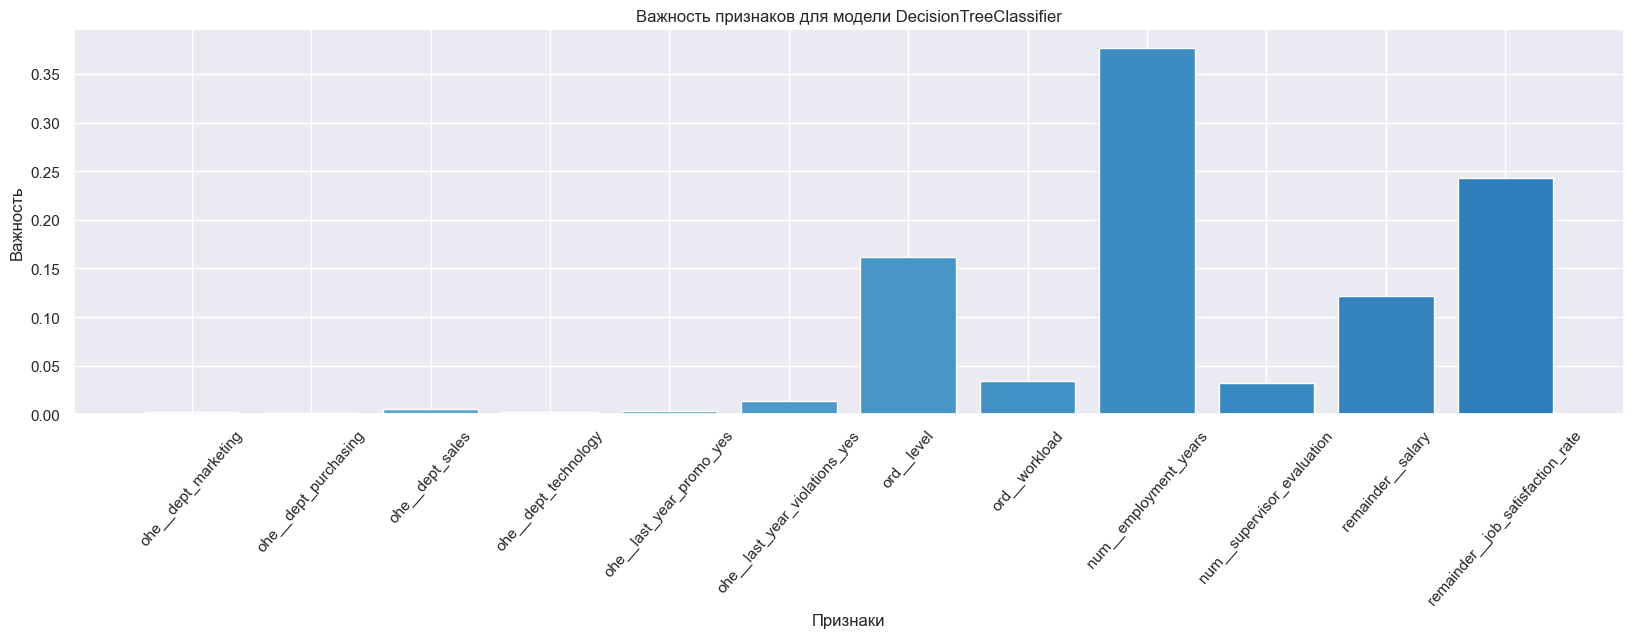

In [176]:
# построим столбчатую диаграмму анализа важности признаков

plt.figure(figsize=(20, 5))
colors = plt.cm.Blues(np.linspace(0.5, 0.7, len(feature_importances_2)))
plt.bar(range(len(feature_names_2)), feature_importances_2, tick_label=feature_names_2, color=colors)
plt.title('Важность признаков для модели DecisionTreeClassifier')
plt.xlabel('Признаки')
plt.ylabel('Важность')
plt.xticks(rotation=49)
plt.show()

Для предсказания увольнения сотрудника модель сочла наиболее важными такие признаки, как количество лет в компании (первое место), уровень удовлетворённости сотрудника работой (второе место), уровень занимаемой должности (третье место), размер заработной платы (четвёртое место). Пятое и шестое места делят между собой уровень загруженности сотрудника и оценка его работы, данная руководителей. На седьмом месте — наличие у сотрудника нарушений трудового договора за последний год. На восьмом — нахождение сотрудника в отделе продаж

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Общий вывод
</div>

---

Для этой задачи лучшей оказалась модель `DecisionTreeClassifier` со следующими параметрами:

- `max_depth`: 9
- `max_features`: 15
- `min_samples_leaf`: 7

Целевая метрика ROC-AUC равна 0.91 на тестовой выборке, что считается очень высоким показателем. `DecisionTreeClassifier` хорошо показывет себя в случаях со сложными и нелинейными зависимостями в данных. DecisionTreeRegressor также прошла проверку на адекватность, совершённую с помощью константной модели DummyRegressor. Проверка закончилась со следующими результатами:
- метрика ROC-AUC модели DecisionTreeRegressor на тестовой выборке: 14.361645
- метрика ROC-AUC модели DummyRegressor на тестовой выборке: 38.226050

---

Больше всего на конечное увольнение влияют количество лет в компании и уровень удовлетворённости работой. Если на первый признак повлиять нельзя, то второй, напротив, вполне можно контролировать. Согласно результатам предыдушей задачи, на удовлетворённость работой сильнее всего влияет оценка работы сотрудника, данная руководителем. Можно рекомендовать бизнесу разработать более эффективную систему оценки работы сотрудников, которая будет лучше учитывать их достижения и вклад в компанию. Это может включать в себя регулярную обратную связь (возможно, анонимную), чёткие критерии оценки и вознаграждения за хорошую работу.

Анализ важности признаков показывает только вклад признака в конечный результат модели, но не указывает на направление этого вклада. То есть, мы не знаем, является ли этот вклад положительным или отрицательным. Значит, анализ важности признаков не показывает нам направление вклада длительности работы в компании. Однако исследовательский анализ позволил сделать вывод, что чаще увольняются те сотрудники, которые работали в компании не больше двух-трёх лет. Возможно, бизнесу также стоит посоветовать разработать эффективную программу адаптации для новых сотрудников, давать им больше возможностей для развития — более интересные проекты и задачи, организовать социальные мероприятия и командообразующие активности, чтобы новые сотрудники могли укрепить отношения с коллегами и почувствовать себя частью команды

---

# Заключение

Для поиска лучшей модели в первой задаче были выбраны такие модели, как `LinearRegression` и `DecisionTreeRegressor`, лучшей из них оказалась `DecisionTreeRegressor`, метрика SMAPE у этой модели равна 14.41 на тестовой выборке. Для второй задачи были выбраны `KNeghborsClassifier`, `DecisionTreeClassifier` и `LogisticRegression` и лучше из них снова оказалась модель, основанная на деревьях решений — `DecisionTreeClassifier` с метрикой ROC-AUC, равной 0.91 на тестовой выборке.

Были успешно созданы две модели, которые предсказывают увольнение сотрудника и его неудовлетворённость работой. Компании стоит обратить внимание на тех сотрудников, которые трудостроены меньше двух лет и являются самыми неопытными — это своего рода группа риска, которая в качестве сотрудников является не очень надёжной для компании. Возможно, джуниоров может пугать низкая зарплата илиотсутствие карьерного роста, перспектиы, возможностей для развития и интересных задач